In [1]:
import numpy as np
import pandas as pd
import os
import cv2

# Set the path to the UTK dataset directory in Kaggle's input folder
path = "/kaggle/input/utkface-new/UTKFace"  # Update the directory path if necessary

# List the files in the UTK cropped dataset directory
if os.path.exists(path):
    files = os.listdir(path)
    size = len(files)
    print("Size: ", size)

Size:  23708


In [2]:
import cv2
images = []

for file in files:
    try:


        img = cv2.imread(path+'/'+file) # Using 0 to read image in grayscale mode
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dim = (96, 96)
        img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA) # resize the original image to 60 * 60 * 3

        images.append(img)
    except Exception as ex:
        continue

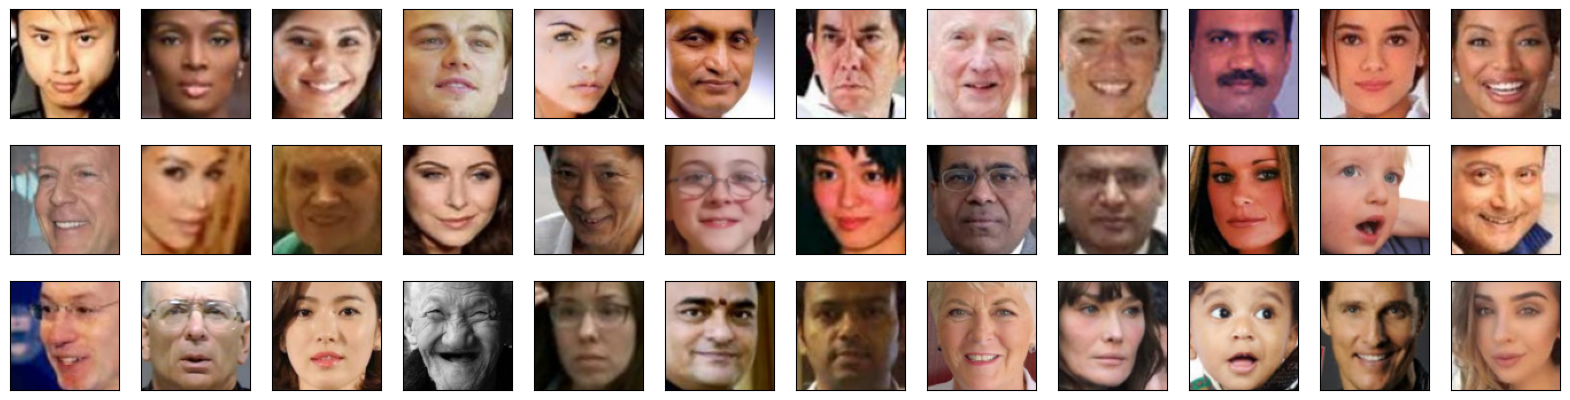

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
def visualize_data():
    images_to_show = 36
    per_row = 12
    fig = plt.figure(figsize=(20,5))
    for i in range(images_to_show):
        pos = (i // per_row, i % per_row)
        ax = plt.subplot2grid((int(images_to_show / per_row), per_row),
                              pos, xticks=[], yticks=[])
        ax.imshow(images[i])
    plt.show()
    fig.savefig('face_demo.png', dpi = 300, bbox_inches='tight')

visualize_data()

In [4]:
import pandas as pd
import os

# Define the path to the dataset in the Kaggle environment
dataset_path = "/kaggle/input/utkface-new/UTKFace"  # Update this if your dataset path is different

# Get the list of files in the dataset directory
files = os.listdir(dataset_path)

# Initialize lists to store valid metadata
age = []
gender = []
race = []

# Iterate over all files in the dataset
for i in files:
    try:
        # Extract age, gender, and race metadata from the filename
        i_age = i.split('_')[0]
        i_gender = i.split('_')[1]
        i_race = i.split('_')[2]

        # Validate the metadata
        if ((int(i_age) not in range(120)) or (i_gender not in ["0", "1"]) or (i_race not in ["0", "1", "2", "3", "4"])):
            print(f"Invalid file: {i}")  # Log invalid file
        else:
            # Append valid metadata to the respective lists
            age.append(i_age)
            gender.append(i_gender)
            race.append(i_race)
    except Exception as e:
        print(f"Error processing file {i}: {e}")

# Create a dictionary to hold the extracted metadata
categories = {
    'Age': age,
    'Race': race,
    'Gender': gender
}

# Convert the dictionary into a pandas DataFrame
df = pd.DataFrame(categories)

# Display the DataFrame
print(df)


Invalid file: 61_1_20170109142408075.jpg.chip.jpg
Invalid file: 61_1_20170109150557335.jpg.chip.jpg
Invalid file: 39_1_20170116174525125.jpg.chip.jpg
      Age Race Gender
0      26    2      0
1      22    1      1
2      21    3      1
3      28    0      0
4      17    4      1
...    ..  ...    ...
23700  41    0      0
23701  42    0      0
23702   2    2      0
23703  65    0      1
23704  66    1      0

[23705 rows x 3 columns]


In [5]:
%%capture
files = os.listdir(path)
images=[]
i=0
for file in files:
  total=path+'/'+file
  print(total," i:",i)
  i=i+1
  image=cv2.imread(total)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image= cv2.resize(image,(64,64))
  images.append(image)

Gender
0    12391
1    11314
Name: count, dtype: int64


([<matplotlib.axis.XTick at 0x7cdf8c8309d0>,
 [Text(0, 0, 'Male'), Text(1, 0, 'Female')])

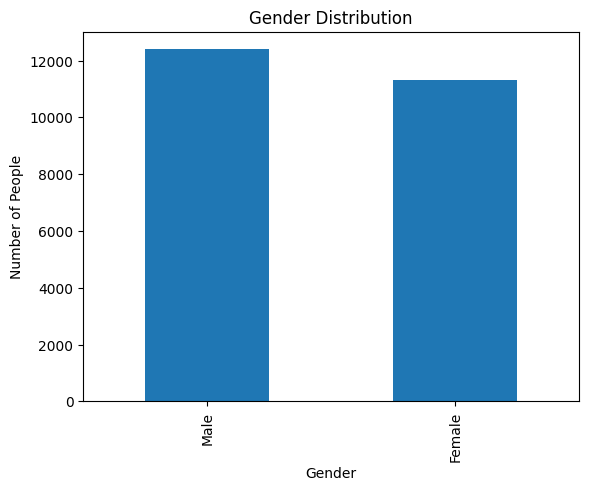

In [6]:
gender_counts = df["Gender"].value_counts()
print(gender_counts)
gender_counts.plot(kind='bar')
plt.title("Gender Distribution")
plt.xlabel('Gender')
plt.ylabel('Number of People')
plt.xticks([0, 1], ['Male', 'Female'])


Race
0    10078
1     4526
3     3975
2     3434
4     1692
Name: count, dtype: int64


([<matplotlib.axis.XTick at 0x7cdf8c8fb610>,
 [Text(0, 0, 'White'),
  Text(1, 0, 'Black'),
  Text(2, 0, 'Asian'),
  Text(3, 0, 'Indian'),
  Text(4, 0, 'Others')])

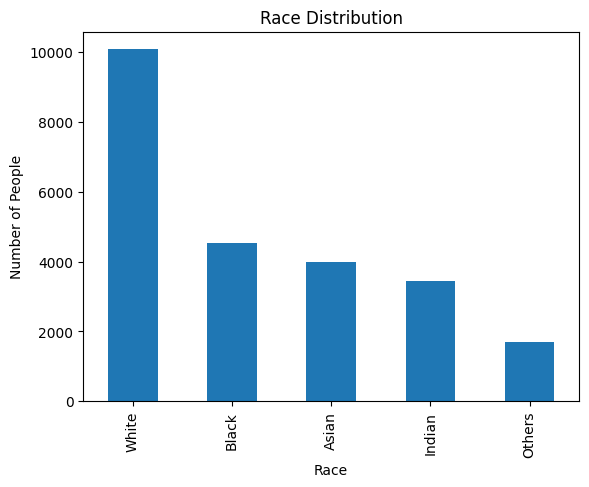

In [7]:
race_counts = df["Race"].value_counts()
print(race_counts)
race_counts.plot(kind='bar')
plt.title("Race Distribution")
plt.xlabel('Race')
plt.ylabel('Number of People')
plt.xticks([0, 1, 2, 3, 4], ['White', 'Black', 'Asian', 'Indian', 'Others'])


Text(0.5, 1.0, 'Age Distribution')

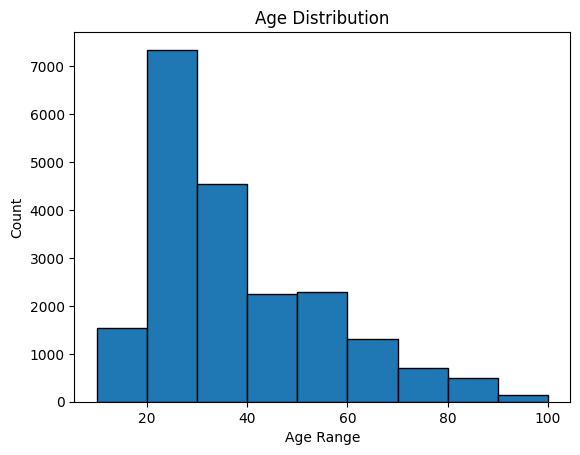

In [8]:
age_ranges = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

age_counts = [sum(1 for i_age in age if int(i_age) >= start and int(i_age) < end) for start, end in zip(age_ranges[:-1], age_ranges[1:])]

plt.bar(age_ranges[:-1], age_counts, width=10, align='edge', edgecolor='black')

plt.xlabel('Age Range')
plt.ylabel('Count')
plt.title('Age Distribution')


## ResNet

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models

class GenderRaceModel(nn.Module):
    def __init__(self, pretrained_path):
        super(GenderRaceModel, self).__init__()
        # Load pretrained ResNet18 model
        self.resnet18 = models.resnet18()
        self.resnet18.load_state_dict(torch.load(pretrained_path))

        # Modify the fully connected layer for multitask classification
        self.resnet18.fc = nn.Identity()  # Remove the original FC layer

        # Add a bottleneck layer to reduce dimensionality
        self.bottleneck = nn.Sequential(
            nn.Linear(512, 256),  # Reduce features from 512 to 256
            nn.ReLU(),
            nn.Dropout(p=0.3)    # Add dropout for regularization
        )

        # Single classification head for 10 classes (2 genders × 5 races)
        self.combined_head = nn.Linear(256, 10)

    def forward(self, x):
        # Extract features using ResNet18 backbone
        features = self.resnet18(x)

        # Apply bottleneck layer
        bottleneck_features = self.bottleneck(features)

        # Predict the combined gender + race class
        combined_output = self.combined_head(bottleneck_features)

        return combined_output


# Instantiate the model
MODEL_PATH = "/kaggle/input/resnet18/resnet18.pth"  # Update with the correct path
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GenderRaceModel(MODEL_PATH)
model.to(DEVICE)

# Print the model architectur
print(model)


<ipython-input-7-6f5d5cc76365>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.resnet18.load_state_dict(torch.load(pretrained_path))


GenderRaceModel(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [15]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [4]:
class UTKFaceDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, num_race_classes=5):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.num_race_classes = num_race_classes  # Define number of race classes to combine labels

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.dataframe.iloc[idx]['filename'])
        image = Image.open(img_path)

        # Convert grayscale to RGB if necessary
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Labels
        gender = self.dataframe.iloc[idx]['gender']
        race = self.dataframe.iloc[idx]['race']

        # Combine gender and race into a single label
        combined_label = gender * self.num_race_classes + race

        return image, torch.tensor(combined_label)


In [18]:
DATA_PATH = "/kaggle/input/utkface-new/UTKFace/"
def reload_data():
    age_list, gender_list, race_list = [], [], []
    datetime_list, filename_list = [], []
    
    for filename in os.listdir(DATA_PATH):
        args = filename.split("_")
        if len(args) < 4:
            age = int(args[0])
            gender = int(args[1])
            race = 4
            datetime = args[2].split(".")[0]
        else:
            age = int(args[0])
            gender = int(args[1])
            race = int(args[2])
            datetime = args[3].split(".")[0]
        
        age_list.append(age)
        gender_list.append(gender)
        race_list.append(race)
        datetime_list.append(datetime)
        filename_list.append(filename)
    
    d = {
        'age': age_list,
        'gender': gender_list,
        'race': race_list,
        'datetime': datetime_list,
        'filename': filename_list
    }
    return pd.DataFrame(data=d)

In [20]:
import pandas as pd

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    #transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [22]:
import pandas as pd

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(p=0.3),
#     #transforms.RandomRotation(degrees=15),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# df = reload_data()
# dataset = UTKFaceDataset(df, DATA_PATH, transform=transform)


# Define dataset split ratios
train_ratio = 0.7  # 70% training
val_ratio = 0.2    # 20% validation
test_ratio = 0.1   # 10% testing

# Calculate dataset sizes
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [7]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define Loss Function
#gender_criterion = nn.CrossEntropyLoss()
#race_criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [8]:
import torch
import os
# Directory to save checkpoints
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Function to save checkpoint
def save_checkpoint(model, optimizer, epoch, loss, accuracy, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy
    }
    torch.save(checkpoint, filename)


In [9]:
NUM_EPOCHS = 20  # Set a high number to allow convergence
PATIENCE = 2  # Stop training after 2 consecutive increases in test loss

# Variables to track early stopping
best_loss = float('inf')
consecutive_increases = 0

for epoch in range(NUM_EPOCHS):
    # ===== Training Phase =====
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, combined_labels in tqdm(train_loader):
        images, combined_labels = images.to(DEVICE), combined_labels.to(DEVICE)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        combined_output = model(images)

        # Calculate loss
        loss = criterion(combined_output, combined_labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track accuracy
        _, preds = torch.max(combined_output, 1)
        correct += (preds == combined_labels).sum().item()
        total += combined_labels.size(0)
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # ===== Testing Phase =====
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, combined_labels in test_loader:
            images, combined_labels = images.to(DEVICE), combined_labels.to(DEVICE)

            # Forward pass
            combined_output = model(images)

            # Calculate loss
            loss = criterion(combined_output, combined_labels)
            test_loss += loss.item()

            # Track accuracy
            _, preds = torch.max(combined_output, 1)
            test_correct += (preds == combined_labels).sum().item()
            test_total += combined_labels.size(0)

    test_loss = test_loss / len(test_loader)
    test_acc = test_correct / test_total
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Save the checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pth')
    save_checkpoint(model, optimizer, epoch, test_loss, test_acc, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

    # Early stopping logic
    if test_loss < best_loss:
        best_loss = test_loss
        consecutive_increases = 0  # Reset the counter if the loss decreases
    else:
        consecutive_increases += 1
        print(f"Test loss increased for {consecutive_increases} consecutive epochs.")

    if consecutive_increases >= PATIENCE:
        print("Early stopping triggered. Training stopped.")
        break

# Save the final model
torch.save(model, 'bias_aware_model_extra.pth')
print("Final model saved as 'bias_aware_model_extra.pth'")


100%|██████████| 519/519 [02:53<00:00,  3.00it/s]


Epoch [1/20], Train Loss: 2.0965, Train Accuracy: 0.2405
Epoch [1/20], Test Loss: 2.0320, Test Accuracy: 0.2618
Checkpoint saved at checkpoints/model_epoch_0.pth


100%|██████████| 519/519 [01:42<00:00,  5.06it/s]


Epoch [2/20], Train Loss: 1.8452, Train Accuracy: 0.3376
Epoch [2/20], Test Loss: 1.6679, Test Accuracy: 0.4056
Checkpoint saved at checkpoints/model_epoch_1.pth


100%|██████████| 519/519 [01:42<00:00,  5.08it/s]


Epoch [3/20], Train Loss: 1.6442, Train Accuracy: 0.4137
Epoch [3/20], Test Loss: 1.4504, Test Accuracy: 0.4629
Checkpoint saved at checkpoints/model_epoch_2.pth


100%|██████████| 519/519 [01:41<00:00,  5.10it/s]


Epoch [4/20], Train Loss: 1.5214, Train Accuracy: 0.4492
Epoch [4/20], Test Loss: 1.8887, Test Accuracy: 0.3739
Checkpoint saved at checkpoints/model_epoch_3.pth
Test loss increased for 1 consecutive epochs.


100%|██████████| 519/519 [01:43<00:00,  4.99it/s]


Epoch [5/20], Train Loss: 1.3831, Train Accuracy: 0.5130
Epoch [5/20], Test Loss: 1.2270, Test Accuracy: 0.5746
Checkpoint saved at checkpoints/model_epoch_4.pth


100%|██████████| 519/519 [01:42<00:00,  5.09it/s]


Epoch [6/20], Train Loss: 1.2935, Train Accuracy: 0.5513
Epoch [6/20], Test Loss: 1.1477, Test Accuracy: 0.6147
Checkpoint saved at checkpoints/model_epoch_5.pth


100%|██████████| 519/519 [01:41<00:00,  5.14it/s]


Epoch [7/20], Train Loss: 1.2215, Train Accuracy: 0.5811
Epoch [7/20], Test Loss: 1.1326, Test Accuracy: 0.6033
Checkpoint saved at checkpoints/model_epoch_6.pth


100%|██████████| 519/519 [01:41<00:00,  5.12it/s]


Epoch [8/20], Train Loss: 1.1632, Train Accuracy: 0.6070
Epoch [8/20], Test Loss: 0.9862, Test Accuracy: 0.6745
Checkpoint saved at checkpoints/model_epoch_7.pth


100%|██████████| 519/519 [01:44<00:00,  4.97it/s]


Epoch [9/20], Train Loss: 1.0942, Train Accuracy: 0.6387
Epoch [9/20], Test Loss: 0.8948, Test Accuracy: 0.7032
Checkpoint saved at checkpoints/model_epoch_8.pth


100%|██████████| 519/519 [01:41<00:00,  5.13it/s]


Epoch [10/20], Train Loss: 1.0425, Train Accuracy: 0.6540
Epoch [10/20], Test Loss: 0.9097, Test Accuracy: 0.7003
Checkpoint saved at checkpoints/model_epoch_9.pth
Test loss increased for 1 consecutive epochs.


100%|██████████| 519/519 [01:42<00:00,  5.07it/s]


Epoch [11/20], Train Loss: 1.0087, Train Accuracy: 0.6674
Epoch [11/20], Test Loss: 0.9311, Test Accuracy: 0.6876
Checkpoint saved at checkpoints/model_epoch_10.pth
Test loss increased for 2 consecutive epochs.
Early stopping triggered. Training stopped.
Final model saved as 'bias_aware_model_extra.pth'


In [ ]:
# NUM_EPOCHS = 10

# for epoch in range(NUM_EPOCHS):
#     # ===== Training Phase =====
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0

#     for images, combined_labels in tqdm(train_loader):
#         images, combined_labels = images.to(DEVICE), combined_labels.to(DEVICE)

#         # Zero gradients
#         optimizer.zero_grad()

#         # Forward pass
#         combined_output = model(images)

#         # Calculate loss
#         loss = criterion(combined_output, combined_labels)

#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()

#         # Track accuracy
#         _, preds = torch.max(combined_output, 1)
#         correct += (preds == combined_labels).sum().item()
#         total += combined_labels.size(0)
#         running_loss += loss.item()

#     train_loss = running_loss / len(train_loader)
#     train_acc = correct / total
#     print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    

#     # ===== Testing Phase =====
#     model.eval()
#     test_loss = 0.0
#     test_correct = 0
#     test_total = 0

#     with torch.no_grad():
#         for images, combined_labels in test_loader:
#             images, combined_labels = images.to(DEVICE), combined_labels.to(DEVICE)

#             # Forward pass
#             combined_output = model(images)

#             # Calculate loss
#             loss = criterion(combined_output, combined_labels)
#             test_loss += loss.item()

#             # Track accuracy
#             _, preds = torch.max(combined_output, 1)
#             test_correct += (preds == combined_labels).sum().item()
#             test_total += combined_labels.size(0)

#     test_loss = test_loss / len(test_loader)
#     test_acc = test_correct / test_total
#     print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
#     checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pth')
#     save_checkpoint(model, optimizer, epoch, test_loss, test_acc, checkpoint_path)
#     print(f"Checkpoint saved at {checkpoint_path}")

# torch.save(model, 'bias_aware_model.pth')
# print("Model saved as 'bias_aware_model.pth'")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

def calculate_metrics(true_labels, predicted_labels, num_classes):
    # Classification Report
    report = classification_report(true_labels, predicted_labels, output_dict=True)
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    print("\nConfusion Matrix:")
    print(cm)

    return report, cm


In [ ]:
all_true_labels = []
all_predicted_labels = []

with torch.no_grad():
    for images, combined_labels in test_loader:
        images, combined_labels = images.to(DEVICE), combined_labels.to(DEVICE)

        # Forward pass
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_true_labels.extend(combined_labels.cpu().numpy())
        all_predicted_labels.extend(preds.cpu().numpy())

# Convert to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate metrics for combined labels
print("Performance Metrics for Combined Gender+Race:")
combined_report, combined_cm = calculate_metrics(all_true_labels, all_predicted_labels, num_classes=10)

# Separate gender and race from combined labels
num_race_classes = 5
true_gender = all_true_labels // num_race_classes
pred_gender = all_predicted_labels // num_race_classes

true_race = all_true_labels % num_race_classes
pred_race = all_predicted_labels % num_race_classes

# Calculate metrics for gender
print("\nPerformance Metrics for Gender:")
gender_report, gender_cm = calculate_metrics(true_gender, pred_gender, num_classes=2)

# Calculate metrics for race
print("\nPerformance Metrics for Race:")
race_report, race_cm = calculate_metrics(true_race, pred_race, num_classes=5)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix", cmap="Blues"):
    """
    Plots a colored confusion matrix.
    
    Args:
        cm (np.ndarray): Confusion matrix.
        class_names (list): List of class names for the axes.
        title (str): Title of the plot.
        cmap (str): Colormap for the heatmap.
    """
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

# Example usage for the combined confusion matrix
class_names_combined = [f"Gender-{i//5} Race-{i%5}" for i in range(10)]
plot_confusion_matrix(combined_cm, class_names_combined, title="Combined Confusion Matrix")

# Example usage for gender confusion matrix
gender_class_names = ["Male", "Female"]
plot_confusion_matrix(gender_cm, gender_class_names, title="Gender Confusion Matrix")

# Example usage for race confusion matrix
race_class_names = ["Race-0", "Race-1", "Race-2", "Race-3", "Race-4"]
plot_confusion_matrix(race_cm, race_class_names, title="Race Confusion Matrix")


In [ ]:
def demographic_parity(true_labels, predicted_labels, sensitive_attribute):
    unique_groups = np.unique(sensitive_attribute)
    group_metrics = {}

    for group in unique_groups:
        group_indices = np.where(sensitive_attribute == group)[0]
        group_preds = predicted_labels[group_indices]

        # Positive rate for the group
        positive_rate = np.sum(group_preds == 1) / len(group_preds)
        group_metrics[group] = positive_rate

    return group_metrics

# Calculate demographic parity for gender
gender_dp = demographic_parity(all_true_labels, all_predicted_labels, true_gender)
print("\nDemographic Parity (Gender):", gender_dp)

# Calculate demographic parity for race
race_dp = demographic_parity(all_true_labels, all_predicted_labels, true_race)
print("\nDemographic Parity (Race):", race_dp)


In [16]:
MODEL_PATH = "/kaggle/input/checkpoints/bias_aware_model (1).pth"
model = torch.load(MODEL_PATH)
model.to(DEVICE)
#model.eval()

<ipython-input-16-4624710dac18>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(MODEL_PATH)


GenderRaceModel(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [17]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics_by_group(model, loader, device, num_race_classes=5):
    # Track metrics for each group
    group_metrics = {}

    with torch.no_grad():
        model.eval()
        for images, combined_labels in loader:
            images, combined_labels = images.to(device), combined_labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for label in range(num_race_classes):
                group_indices = (combined_labels == label).nonzero(as_tuple=True)[0]
                if len(group_indices) > 0:
                    group_preds = preds[group_indices]
                    group_labels = combined_labels[group_indices]
                    
                    accuracy = accuracy_score(group_labels.cpu(), group_preds.cpu())
                    precision = precision_score(group_labels.cpu(), group_preds.cpu(), average='weighted')
                    recall = recall_score(group_labels.cpu(), group_preds.cpu(), average='weighted')
                    f1 = f1_score(group_labels.cpu(), group_preds.cpu(), average='weighted')
                    
                    if label not in group_metrics:
                        group_metrics[label] = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
                    
                    group_metrics[label]['accuracy'].append(accuracy)
                    group_metrics[label]['precision'].append(precision)
                    group_metrics[label]['recall'].append(recall)
                    group_metrics[label]['f1'].append(f1)
    
    # Summarize group metrics
    for group, metrics in group_metrics.items():
        print(f"Group {group}:")
        print(f"  Accuracy: {np.mean(metrics['accuracy']):.4f}")
        print(f"  Precision: {np.mean(metrics['precision']):.4f}")
        print(f"  Recall: {np.mean(metrics['recall']):.4f}")
        print(f"  F1-Score: {np.mean(metrics['f1']):.4f}")

# Evaluate bias
compute_metrics_by_group(model, test_loader, DEVICE)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Group 0:
  Accuracy: 0.7627
  Precision: 0.9867
  Recall: 0.7627
  F1-Score: 0.8507
Group 1:
  Accuracy: 0.8463
  Precision: 0.9583
  Recall: 0.8463
  F1-Score: 0.8901
Group 2:
  Accuracy: 0.8241
  Precision: 0.9552
  Recall: 0.8241
  F1-Score: 0.8715
Group 3:
  Accuracy: 0.8345
  Precision: 0.9429
  Recall: 0.8345
  F1-Score: 0.8764
Group 4:
  Accuracy: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

In [ ]:
from collections import Counter
print(Counter(train_labels))
print(Counter(test_labels))


## GradCAM

In [1]:
import torch
import numpy as np
import os
import cv2

In [2]:

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.output = None

        # Register hooks for saving gradients and feature map outputs
        self.target_layer.register_forward_hook(self.save_output)
        self.target_layer.register_full_backward_hook(self.save_gradients)

    def save_output(self, module, input, output):
        self.output = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        # Forward pass
        output = self.model(x)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()  
        
        self.model.zero_grad()
        class_score = output[:, class_idx]
        class_score.backward()

        # Pool gradients over spatial dimensions
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])

        # Weight feature maps by gradients
        for i in range(self.output.size(1)):
            self.output[:, i, :, :] *= pooled_gradients[i]

        # Generate heatmap
        heatmap = torch.mean(self.output, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu().data.numpy(), 0)  # ReLU activation
        heatmap /= np.max(heatmap)  # Normalize heatmap
        return heatmap

In [3]:
def generate_gradcam(model, dataset, target_layer):
    """
    Generates Grad-CAM heatmaps for all samples in the dataset.
    Args:
        model: The trained model.
        dataset: The UTKFaceDataset instance.
        target_layer: The layer of the model to visualize.

    Returns:
        List of tuples (heatmap, filename).
    """
    model.eval()  # Set the model to evaluation mode
    gradcam = GradCAM(model=model, target_layer=target_layer)  # Initialize Grad-CAM
    heatmaps = []  # To store generated heatmaps

    for idx in range(len(dataset)):
        image, _ = dataset[idx]  # Get the image and label
        image = image.unsqueeze(0).to(DEVICE)  # Add batch dimension and move to device
        heatmap = gradcam(image)  # Generate Grad-CAM heatmap
        
        # Extract the filename from the dataset
        filename = dataset.dataframe.iloc[idx]['filename']
        
        # Normalize the heatmap safely
        if np.max(heatmap) > 0:
            heatmap /= np.max(heatmap)
        else:
            heatmap = np.zeros_like(heatmap)  # Handle cases where the heatmap has all zeros

        heatmaps.append((heatmap, filename))  # Store heatmap and filename

    return heatmaps


In [4]:
import cv2
import numpy as np
import os

def save_gradcam(heatmap, img, output_dir, filename):
    """
    Saves the Grad-CAM heatmap overlay on the original image.

    Args:
        heatmap: The heatmap (2D array) generated by Grad-CAM.
        img: The original image (PIL Image).
        output_dir: Directory where the overlay image will be saved.
        filename: Name of the output file.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Normalize the heatmap to [0, 255]
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / heatmap.max()
    heatmap = np.uint8(255 * heatmap)

    # Apply the colormap
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert the original PIL image to NumPy array
    img_np = np.array(img)

    # Ensure the image has 3 channels (RGB)
    if len(img_np.shape) == 2:  # If grayscale, convert to RGB
        img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)

    # Resize heatmap to match the image size
    heatmap_colored = cv2.resize(heatmap_colored, (img_np.shape[1], img_np.shape[0]))

    # Overlay heatmap on the original image
    overlay = cv2.addWeighted(img_np, 0.5, heatmap_colored, 0.5, 0)

    # Convert BGR to RGB before saving
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Save the overlay image
    output_path = os.path.join(output_dir, filename)
    #cv2.imwrite(output_path, overlay)
    Image.fromarray(overlay).save(output_path)
    print(f"Saved Grad-CAM overlay to {output_path}")


In [ ]:
# Load the model
MODEL_PATH = "/kaggle/input/checkpoints/bias_aware_model (1).pth"
model = torch.load(MODEL_PATH)
model.to(DEVICE)
model.eval()

# Define target layer
target_layer = model.resnet18.layer4[1].conv2

heatmaps = generate_gradcam(model, dataset, target_layer)
# Generate Grad-CAM heatmaps
output_dir = "gradcam_results1"
os.makedirs(output_dir, exist_ok=True)

for heatmap, filename in heatmaps:
    img_path = os.path.join(DATA_PATH, filename)
    img = Image.open(img_path).convert('RGB')
    save_gradcam(heatmap, img, output_dir, f"{filename}_gradcam.jpg")


In [ ]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import numpy as np
import os

def display_gradcam_results(dataset, heatmaps, output_dir="gradcam_results1", num_images=5):
    """
    Displays and saves Grad-CAM results for a subset of images.
    Args:
        dataset: Dataset object containing images and labels.
        heatmaps: List of (heatmap, filename) pairs.
        output_dir: Directory to save Grad-CAM results.
        num_images: Number of Grad-CAM results to display.
    """
    os.makedirs(output_dir, exist_ok=True)
    plt.figure(figsize=(15, num_images * 5))

    for idx, (heatmap, filename) in enumerate(heatmaps[:num_images]):
        # Load the original image
        img_path = os.path.join(DATA_PATH, filename)
        original_image = Image.open(img_path).convert('RGB')

        # Resize heatmap to the size of the original image
        heatmap = cv2.resize(heatmap, original_image.size)
        heatmap = np.uint8(255 * heatmap)  # Scale heatmap to 0-255
        heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)  # Convert to RGB format

        # Convert original image to NumPy array
        original_image_np = np.array(original_image)

        # Blend the original image with the heatmap
        overlay = np.uint8(original_image_np * 0.5 + heatmap_colored * 0.5)

        # Save the overlay image
        output_path = os.path.join(output_dir, f"{filename}_gradcam_overlay.jpg")
        Image.fromarray(overlay).save(output_path)

        # Plot the original image and Grad-CAM overlay
        plt.subplot(num_images, 2, idx * 2 + 1)
        plt.imshow(original_image_np)
        plt.axis("off")
        plt.title(f"Original Image: {filename}")

        plt.subplot(num_images, 2, idx * 2 + 2)
        plt.imshow(overlay)
        plt.axis("off")
        plt.title(f"Grad-CAM Overlay: {filename}")

    plt.tight_layout()
    plt.show()


In [ ]:
display_gradcam_results(dataset, heatmaps, output_dir="gradcam_results", num_images=10)


In [ ]:
import shutil

# Function to zip the output folder
def zip_output_folder(output_folder, zip_name):
    shutil.make_archive(zip_name, 'zip', output_folder)
    print(f"Zipped the folder '{output_folder}' into '{zip_name}.zip'")

# Path to the output folder and the desired zip file name
output_folder = "/kaggle/working/gradcam_results1"  # Same folder used earlier
zip_name = "/kaggle/working/gradcam_results1"  # Name for the zip file (without extension)

# Call the function to zip the folder
zip_output_folder(output_folder, zip_name)

## Bbox

In [ ]:
pip install mediapipe

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# Initialize MediaPipe Face Detection
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# Function to generate ground truth mask for the lips and nose regions
def generate_lips_and_nose_mask(image, landmarks):
    h, w, _ = image.shape
    mask = np.zeros((h, w), dtype=np.uint8)
    
    # Define the lips region using landmark indices (MediaPipe indices)
    lips_indices = [
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 310, 415, 312, 311, 310, 78, 95, 88, 178, 87
    ]
    lips_points = [(int(landmarks[idx].x * w), int(landmarks[idx].y * h)) for idx in lips_indices]
    
    # Define the nose region using landmark indices
    nose_indices = [
        1, 2, 98, 327, 330, 168  # Key landmarks around the nose
    ]
    nose_points = [(int(landmarks[idx].x * w), int(landmarks[idx].y * h)) for idx in nose_indices]
    
    # Create polygons for the lips and nose regions
    cv2.fillPoly(mask, [np.array(lips_points)], 255)  # Lips
    cv2.fillPoly(mask, [np.array(nose_points)], 255)  # Nose
    
    return mask

# Function to process a single image and generate a combined mask for lips and nose
def process_single_image(image_path):
    # Load the input image
    input_image = cv2.imread(image_path)
    
    if input_image is None:
        print(f"Could not load image: {image_path}")
        return
    
    # Process the image with MediaPipe
    results = face_mesh.process(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # Generate the lips and nose mask
            lips_nose_mask = generate_lips_and_nose_mask(input_image, face_landmarks.landmark)
            
            # Combine the original image with the lips and nose mask for visualization
            combined = cv2.addWeighted(input_image, 0.6, cv2.cvtColor(lips_nose_mask, cv2.COLOR_GRAY2BGR), 0.4, 0)
            
            # Convert images to RGB for matplotlib
            input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
            lips_nose_mask_rgb = cv2.cvtColor(lips_nose_mask, cv2.COLOR_GRAY2RGB)
            combined_rgb = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)
            
            # Display the results using matplotlib
            plt.figure(figsize=(10, 10))
            
            plt.subplot(1, 3, 1)
            plt.imshow(input_image_rgb)
            plt.title("Original Image")
            plt.axis("off")
            
            plt.subplot(1, 3, 2)
            plt.imshow(lips_nose_mask_rgb)
            plt.title("Lips and Nose Mask")
            plt.axis("off")
            
            plt.subplot(1, 3, 3)
            plt.imshow(combined_rgb)
            plt.title("Combined Visualization")
            plt.axis("off")
            
            plt.show()
    else:
        print(f"No face detected in {image_path}")

# Path to the specific image
image_path = "/kaggle/input/utkface-new/UTKFace/10_0_0_20170110220235233.jpg.chip.jpg"  # Path to the specific image

# Run the processing for the specific image
process_single_image(image_path)

In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# Initialize MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# Define the indices for lips and nose landmarks
lips_indices = [
    61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 310, 415, 312, 311, 310, 78, 95, 88, 178, 87
]
nose_indices = [
    1, 2, 98, 327, 330, 168  # Key landmarks around the nose
]

# Function to generate bounding box coordinates
def get_bounding_box(landmarks, indices, width, height):
    # Get the coordinates of the specified landmarks
    points = [(landmarks[idx].x * width, landmarks[idx].y * height) for idx in indices]
    
    # Find the bounding box: min and max x and y
    min_x = min([point[0] for point in points])
    max_x = max([point[0] for point in points])
    min_y = min([point[1] for point in points])
    max_y = max([point[1] for point in points])
    
    return (int(min_x), int(min_y), int(max_x), int(max_y))

# Function to process a single image and calculate the bounding boxes for lips and nose
def process_single_image(image_path):
    # Load the input image
    input_image = cv2.imread(image_path)
    
    if input_image is None:
        print(f"Could not load image: {image_path}")
        return
    
    # Get image dimensions
    height, width, _ = input_image.shape
    
    # Process the image with MediaPipe
    results = face_mesh.process(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # Get bounding boxes for lips and nose
            lips_bbox = get_bounding_box(face_landmarks.landmark, lips_indices, width, height)
            nose_bbox = get_bounding_box(face_landmarks.landmark, nose_indices, width, height)
            
            # Draw bounding boxes on the image
            cv2.rectangle(input_image, (lips_bbox[0], lips_bbox[1]), (lips_bbox[2], lips_bbox[3]), (0, 255, 0), 2)
            cv2.rectangle(input_image, (nose_bbox[0], nose_bbox[1]), (nose_bbox[2], nose_bbox[3]), (0, 0, 255), 2)
            
            # Convert the image to RGB for visualization
            input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
            
            # Display the image with bounding boxes
            plt.figure(figsize=(8, 8))
            plt.imshow(input_image_rgb)
            plt.title("Image with Lips and Nose Bounding Boxes")
            plt.axis("off")
            plt.show()

    else:
        print(f"No face detected in {image_path}")

# Path to the specific image
image_path = "/kaggle/input/utkface-new/UTKFace/10_0_0_20170110220235233.jpg.chip.jpg"  # Path to the specific image

# Run the processing for the specific image
process_single_image(image_path)

In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# Initialize MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# Define the indices for lips and nose landmarks
lips_indices = [
    61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 310, 415, 312, 311, 310, 78, 95, 88, 178, 87
]
nose_indices = [
    1, 2, 98, 327, 330, 168  # Key landmarks around the nose
]

# Function to generate bounding box coordinates
def get_bounding_box(landmarks, indices, width, height):
    # Get the coordinates of the specified landmarks
    points = [(landmarks[idx].x * width, landmarks[idx].y * height) for idx in indices]
    
    # Find the bounding box: min and max x and y
    min_x = min([point[0] for point in points])
    max_x = max([point[0] for point in points])
    min_y = min([point[1] for point in points])
    max_y = max([point[1] for point in points])
    
    return (int(min_x), int(min_y), int(max_x), int(max_y))

# Function to calculate the combined bounding box
def combine_bounding_boxes(bbox1, bbox2):
    # Find the union of the two bounding boxes
    min_x = min(bbox1[0], bbox2[0])
    min_y = min(bbox1[1], bbox2[1])
    max_x = max(bbox1[2], bbox2[2])
    max_y = max(bbox1[3], bbox2[3])
    
    return (min_x, min_y, max_x, max_y)

# Function to process a single image and calculate the bounding boxes
def process_single_image(image_path):
    # Load the input image
    input_image = cv2.imread(image_path)
    
    if input_image is None:
        print(f"Could not load image: {image_path}")
        return
    
    # Get image dimensions
    height, width, _ = input_image.shape
    
    # Process the image with MediaPipe
    results = face_mesh.process(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # Get bounding boxes for lips and nose
            lips_bbox = get_bounding_box(face_landmarks.landmark, lips_indices, width, height)
            nose_bbox = get_bounding_box(face_landmarks.landmark, nose_indices, width, height)
            
            # Combine the bounding boxes
            combined_bbox = combine_bounding_boxes(lips_bbox, nose_bbox)
            
            # Draw the combined bounding box on the image
            cv2.rectangle(input_image, (combined_bbox[0], combined_bbox[1]), 
                          (combined_bbox[2], combined_bbox[3]), (255, 0, 0), 2)
            
            # Convert the image to RGB for visualization
            input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
            
            # Display the image with the bounding box
            plt.figure(figsize=(8, 8))
            plt.imshow(input_image_rgb)
            plt.title("Image with Combined Lips and Nose Bounding Box")
            plt.axis("off")
            plt.show()

    else:
        print(f"No face detected in {image_path}")

# Path to the specific image
image_path = "/kaggle/input/utkface-new/UTKFace/10_0_0_20170110220235233.jpg.chip.jpg"  # Path to the specific image

# Run the processing for the specific image
process_single_image(image_path)

In [ ]:
import os
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# Initialize MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# Define the indices for lips and nose landmarks
lips_indices = [
    61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 310, 415, 312, 311, 310, 78, 95, 88, 178, 87
]
nose_indices = [
    1, 2, 98, 327, 330, 168  # Key landmarks around the nose
]

# Function to generate bounding box coordinates
def get_bounding_box(landmarks, indices, width, height):
    points = [(landmarks[idx].x * width, landmarks[idx].y * height) for idx in indices]
    min_x = min([point[0] for point in points])
    max_x = max([point[0] for point in points])
    min_y = min([point[1] for point in points])
    max_y = max([point[1] for point in points])
    return (int(min_x), int(min_y), int(max_x), int(max_y))

# Function to calculate the combined bounding box
def combine_bounding_boxes(bbox1, bbox2):
    min_x = min(bbox1[0], bbox2[0])
    min_y = min(bbox1[1], bbox2[1])
    max_x = max(bbox1[2], bbox2[2])
    max_y = max(bbox1[3], bbox2[3])
    return (min_x, min_y, max_x, max_y)

# Function to process all images in a folder
def process_images_in_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through all images in the input folder
    for filename in os.listdir(input_folder):
        # Construct the full image path
        image_path = os.path.join(input_folder, filename)

        # Load the image
        input_image = cv2.imread(image_path)
        if input_image is None:
            print(f"Could not load image: {filename}")
            continue

        # Get image dimensions
        height, width, _ = input_image.shape

        # Process the image with MediaPipe
        results = face_mesh.process(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))

        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # Get bounding boxes for lips and nose
                lips_bbox = get_bounding_box(face_landmarks.landmark, lips_indices, width, height)
                nose_bbox = get_bounding_box(face_landmarks.landmark, nose_indices, width, height)

                # Combine the bounding boxes
                combined_bbox = combine_bounding_boxes(lips_bbox, nose_bbox)

                # Draw the combined bounding box on the image
                cv2.rectangle(input_image, (combined_bbox[0], combined_bbox[1]),
                              (combined_bbox[2], combined_bbox[3]), (255, 0, 0), 2)

        # Save the processed image to the output folder
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, input_image)

        # print(f"Processed and saved: {filename}")

# Input and output folder paths
input_folder = "/kaggle/input/utkface-new/UTKFace"  # Path to the input images
output_folder = "/kaggle/working/nose_lips_bbox_images"  # Path to save processed images

# Process all images in the folder
process_images_in_folder(input_folder, output_folder)

In [ ]:
import shutil

# Function to zip the output folder
def zip_output_folder(output_folder, zip_name):
    shutil.make_archive(zip_name, 'zip', output_folder)
    print(f"Zipped the folder '{output_folder}' into '{zip_name}.zip'")

# Path to the output folder and the desired zip file name
output_folder = "/kaggle/working/nose_lips_bbox_images"  # Same folder used earlier
zip_name = "/kaggle/working/nose_lips_bbox_images"  # Name for the zip file (without extension)

# Call the function to zip the folder
zip_output_folder(output_folder, zip_name)

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# Initialize MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# Function to generate ground truth mask for the eyes, eyebrows, and nose regions
def generate_eyes_eyebrows_and_nose_mask(image, landmarks):
    h, w, _ = image.shape
    mask = np.zeros((h, w), dtype=np.uint8)
    
    # Define the left eye region using landmark indices
    left_eye_indices = [33, 133, 246, 161, 160, 159, 158, 157, 173]
    left_eye_points = [(int(landmarks[idx].x * w), int(landmarks[idx].y * h)) for idx in left_eye_indices]
    
    # Define the right eye region using landmark indices
    right_eye_indices = [362, 263, 466, 388, 387, 386, 385, 384, 398]
    right_eye_points = [(int(landmarks[idx].x * w), int(landmarks[idx].y * h)) for idx in right_eye_indices]
    
    # Define the left eyebrow region using landmark indices
    left_eyebrow_indices = [70, 63, 105, 66, 107, 55, 193]
    left_eyebrow_points = [(int(landmarks[idx].x * w), int(landmarks[idx].y * h)) for idx in left_eyebrow_indices]
    
    # Define the right eyebrow region using landmark indices
    right_eyebrow_indices = [336, 296, 334, 293, 300, 276, 283]
    right_eyebrow_points = [(int(landmarks[idx].x * w), int(landmarks[idx].y * h)) for idx in right_eyebrow_indices]
    
    # Define the nose region using landmark indices
    nose_indices = [1, 2, 98, 327, 330, 168]  # Key landmarks around the nose
    nose_points = [(int(landmarks[idx].x * w), int(landmarks[idx].y * h)) for idx in nose_indices]
    
    # Create polygons for the eyes, eyebrows, and nose regions
    cv2.fillPoly(mask, [np.array(left_eye_points)], 255)  # Left Eye
    cv2.fillPoly(mask, [np.array(right_eye_points)], 255)  # Right Eye
    cv2.fillPoly(mask, [np.array(left_eyebrow_points)], 255)  # Left Eyebrow
    cv2.fillPoly(mask, [np.array(right_eyebrow_points)], 255)  # Right Eyebrow
    cv2.fillPoly(mask, [np.array(nose_points)], 255)  # Nose
    
    return mask

# Function to process a single image and generate a combined mask for eyes, eyebrows, and nose
def process_single_image(image_path):
    # Load the input image
    input_image = cv2.imread(image_path)
    
    if input_image is None:
        print(f"Could not load image: {image_path}")
        return
    
    # Process the image with MediaPipe
    results = face_mesh.process(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # Generate the eyes, eyebrows, and nose mask
            mask = generate_eyes_eyebrows_and_nose_mask(input_image, face_landmarks.landmark)
            
            # Combine the original image with the mask for visualization
            combined = cv2.addWeighted(input_image, 0.6, cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR), 0.4, 0)
            
            # Convert images to RGB for matplotlib
            input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
            mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
            combined_rgb = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)
            
            # Display the results using matplotlib
            plt.figure(figsize=(10, 10))
            
            plt.subplot(1, 3, 1)
            plt.imshow(input_image_rgb)
            plt.title("Original Image")
            plt.axis("off")
            
            plt.subplot(1, 3, 2)
            plt.imshow(mask_rgb)
            plt.title("Eyes, Eyebrows, and Nose Mask")
            plt.axis("off")
            
            plt.subplot(1, 3, 3)
            plt.imshow(combined_rgb)
            plt.title("Combined Visualization")
            plt.axis("off")
            
            plt.show()
    else:
        print(f"No face detected in {image_path}")

# Path to the specific image
image_path = "/kaggle/input/utkface-new/UTKFace/10_0_0_20170110220235233.jpg.chip.jpg"  # Path to the specific image

# Run the processing for the specific image
process_single_image(image_path)

In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# Initialize MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# Define the indices for each facial region
nose_indices = [
    1, 2, 98, 327, 330, 168
]
left_eye_indices = [
    33, 160, 158, 133, 153, 144, 362, 398, 384, 385, 386, 387, 388, 263
]
right_eye_indices = [
    362, 398, 384, 385, 386, 387, 388, 263, 249, 390, 373, 374, 380
]
left_eyebrow_indices = [
    55, 65, 52, 53, 46
]
right_eyebrow_indices = [
    285, 295, 282, 283, 276
]

# Function to generate bounding box coordinates
def get_bounding_box(landmarks, indices, width, height):
    # Get the coordinates of the specified landmarks
    points = [(landmarks[idx].x * width, landmarks[idx].y * height) for idx in indices]
    
    # Find the bounding box: min and max x and y
    min_x = min([point[0] for point in points])
    max_x = max([point[0] for point in points])
    min_y = min([point[1] for point in points])
    max_y = max([point[1] for point in points])
    
    return (int(min_x), int(min_y), int(max_x), int(max_y))

# Function to process a single image and calculate the bounding boxes
def process_single_image(image_path):
    # Load the input image
    input_image = cv2.imread(image_path)
    
    if input_image is None:
        print(f"Could not load image: {image_path}")
        return
    
    # Get image dimensions
    height, width, _ = input_image.shape
    
    # Process the image with MediaPipe
    results = face_mesh.process(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # Get bounding boxes for each facial region
            nose_bbox = get_bounding_box(face_landmarks.landmark, nose_indices, width, height)
            left_eye_bbox = get_bounding_box(face_landmarks.landmark, left_eye_indices, width, height)
            right_eye_bbox = get_bounding_box(face_landmarks.landmark, right_eye_indices, width, height)
            left_eyebrow_bbox = get_bounding_box(face_landmarks.landmark, left_eyebrow_indices, width, height)
            right_eyebrow_bbox = get_bounding_box(face_landmarks.landmark, right_eyebrow_indices, width, height)
            
            # Draw bounding boxes on the image
            cv2.rectangle(input_image, (nose_bbox[0], nose_bbox[1]), (nose_bbox[2], nose_bbox[3]), (0, 0, 255), 2)
            cv2.rectangle(input_image, (left_eye_bbox[0], left_eye_bbox[1]), (left_eye_bbox[2], left_eye_bbox[3]), (255, 255, 0), 2)
            cv2.rectangle(input_image, (right_eye_bbox[0], right_eye_bbox[1]), (right_eye_bbox[2], right_eye_bbox[3]), (255, 255, 0), 2)
            cv2.rectangle(input_image, (left_eyebrow_bbox[0], left_eyebrow_bbox[1]), (left_eyebrow_bbox[2], left_eyebrow_bbox[3]), (255, 0, 255), 2)
            cv2.rectangle(input_image, (right_eyebrow_bbox[0], right_eyebrow_bbox[1]), (right_eyebrow_bbox[2], right_eyebrow_bbox[3]), (255, 0, 255), 2)
            
            # Convert the image to RGB for visualization
            input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
            
            # Display the image with bounding boxes
            plt.figure(figsize=(8, 8))
            plt.imshow(input_image_rgb)
            plt.title("Image with Facial Region Bounding Boxes")
            plt.axis("off")
            plt.show()

    else:
        print(f"No face detected in {image_path}")

# Path to the specific image
image_path = "/kaggle/input/utkface-new/UTKFace/10_0_0_20170110220235233.jpg.chip.jpg"  # Path to the specific image

# Run the processing for the specific image
process_single_image(image_path)

In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# Initialize MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# Define the indices for eyes, eyebrows, and nose landmarks
left_eye_indices = [33, 133, 246, 161, 160, 159, 158, 157, 173]
right_eye_indices = [362, 263, 466, 388, 387, 386, 385, 384, 398]
left_eyebrow_indices = [70, 63, 105, 66, 107, 55, 193]
right_eyebrow_indices = [336, 296, 334, 293, 300, 276, 283]
nose_indices = [1, 2, 98, 327, 330, 168]  # Key landmarks around the nose

# Function to generate bounding box coordinates
def get_bounding_box(landmarks, indices, width, height):
    # Get the coordinates of the specified landmarks
    points = [(landmarks[idx].x * width, landmarks[idx].y * height) for idx in indices]
    
    # Find the bounding box: min and max x and y
    min_x = min([point[0] for point in points])
    max_x = max([point[0] for point in points])
    min_y = min([point[1] for point in points])
    max_y = max([point[1] for point in points])
    
    return (int(min_x), int(min_y), int(max_x), int(max_y))

# Function to calculate the combined bounding box
def combine_bounding_boxes(*bboxes):
    # Initialize min and max values
    min_x = min([bbox[0] for bbox in bboxes])
    min_y = min([bbox[1] for bbox in bboxes])
    max_x = max([bbox[2] for bbox in bboxes])
    max_y = max([bbox[3] for bbox in bboxes])
    
    return (min_x, min_y, max_x, max_y)

# Function to process a single image and calculate the bounding boxes
def process_single_image(image_path):
    # Load the input image
    input_image = cv2.imread(image_path)
    
    if input_image is None:
        print(f"Could not load image: {image_path}")
        return
    
    # Get image dimensions
    height, width, _ = input_image.shape
    
    # Process the image with MediaPipe
    results = face_mesh.process(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # Get bounding boxes for eyes, eyebrows, and nose
            left_eye_bbox = get_bounding_box(face_landmarks.landmark, left_eye_indices, width, height)
            right_eye_bbox = get_bounding_box(face_landmarks.landmark, right_eye_indices, width, height)
            left_eyebrow_bbox = get_bounding_box(face_landmarks.landmark, left_eyebrow_indices, width, height)
            right_eyebrow_bbox = get_bounding_box(face_landmarks.landmark, right_eyebrow_indices, width, height)
            nose_bbox = get_bounding_box(face_landmarks.landmark, nose_indices, width, height)
            
            # Combine the bounding boxes
            combined_bbox = combine_bounding_boxes(
                left_eye_bbox, right_eye_bbox, left_eyebrow_bbox, right_eyebrow_bbox, nose_bbox
            )
            
            # Draw the combined bounding box on the image
            cv2.rectangle(input_image, (combined_bbox[0], combined_bbox[1]), 
                          (combined_bbox[2], combined_bbox[3]), (255, 0, 0), 2)
            
            # Convert the image to RGB for visualization
            input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
            
            # Display the image with the bounding box
            plt.figure(figsize=(8, 8))
            plt.imshow(input_image_rgb)
            plt.title("Image with Combined Eyes, Eyebrows, and Nose Bounding Box")
            plt.axis("off")
            plt.show()

    else:
        print(f"No face detected in {image_path}")

# Path to the specific image
image_path = "/kaggle/input/utkface-new/UTKFace/10_0_0_20170110220235233.jpg.chip.jpg"  # Path to the specific image

# Run the processing for the specific image
process_single_image(image_path)

In [ ]:
import os
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# Initialize MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# Define the indices for eyes, eyebrows, and nose landmarks
left_eye_indices = [33, 133, 246, 161, 160, 159, 158, 157, 173]
right_eye_indices = [362, 263, 466, 388, 387, 386, 385, 384, 398]
left_eyebrow_indices = [70, 63, 105, 66, 107, 55, 193]
right_eyebrow_indices = [336, 296, 334, 293, 300, 276, 283]
nose_indices = [1, 2, 98, 327, 330, 168]  # Key landmarks around the nose

# Function to generate bounding box coordinates
def get_bounding_box(landmarks, indices, width, height):
    points = [(landmarks[idx].x * width, landmarks[idx].y * height) for idx in indices]
    min_x = min([point[0] for point in points])
    max_x = max([point[0] for point in points])
    min_y = min([point[1] for point in points])
    max_y = max([point[1] for point in points])
    return (int(min_x), int(min_y), int(max_x), int(max_y))

# Function to calculate the combined bounding box
def combine_bounding_boxes(*bboxes):
    min_x = min([bbox[0] for bbox in bboxes])
    min_y = min([bbox[1] for bbox in bboxes])
    max_x = max([bbox[2] for bbox in bboxes])
    max_y = max([bbox[3] for bbox in bboxes])
    return (min_x, min_y, max_x, max_y)

# Function to process all images in a folder
def process_images_in_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through all images in the input folder
    for filename in os.listdir(input_folder):
        # Construct the full image path
        image_path = os.path.join(input_folder, filename)

        # Load the image
        input_image = cv2.imread(image_path)
        if input_image is None:
            print(f"Could not load image: {filename}")
            continue

        # Get image dimensions
        height, width, _ = input_image.shape

        # Process the image with MediaPipe
        results = face_mesh.process(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))

        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # Get bounding boxes for eyes, eyebrows, and nose
                left_eye_bbox = get_bounding_box(face_landmarks.landmark, left_eye_indices, width, height)
                right_eye_bbox = get_bounding_box(face_landmarks.landmark, right_eye_indices, width, height)
                left_eyebrow_bbox = get_bounding_box(face_landmarks.landmark, left_eyebrow_indices, width, height)
                right_eyebrow_bbox = get_bounding_box(face_landmarks.landmark, right_eyebrow_indices, width, height)
                nose_bbox = get_bounding_box(face_landmarks.landmark, nose_indices, width, height)

                # Combine the bounding boxes
                combined_bbox = combine_bounding_boxes(
                    left_eye_bbox, right_eye_bbox, left_eyebrow_bbox, right_eyebrow_bbox, nose_bbox
                )

                # Draw the combined bounding box on the image
                cv2.rectangle(input_image, (combined_bbox[0], combined_bbox[1]),
                              (combined_bbox[2], combined_bbox[3]), (255, 0, 0), 2)

        # Save the processed image to the output folder
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, input_image)

        # Uncomment this line if you want to see filenames being processed
        # print(f"Processed and saved: {filename}")

# Input and output folder paths
input_folder = "/kaggle/input/utkface-new/UTKFace"  # Path to the input images
output_folder = "/kaggle/working/eyes_eyebrows_nose_bbox_images"  # Path to save processed images

# Process all images in the folder
process_images_in_folder(input_folder, output_folder)

In [ ]:
import shutil

# Function to zip the output folder
def zip_output_folder(output_folder, zip_name):
    shutil.make_archive(zip_name, 'zip', output_folder)
    print(f"Zipped the folder '{output_folder}' into '{zip_name}.zip'")

# Path to the output folder and the desired zip file name
output_folder = "/kaggle/working/eyes_eyebrows_nose_bbox_images"  # Same folder used earlier
zip_name = "/kaggle/working/eyes_eyebrows_nose_bbox_images"  # Name for the zip file (without extension)

# Call the function to zip the folder
zip_output_folder(output_folder, zip_name)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import glob
 
# Define the directory paths
input_directory = "/kaggle/input/gradcam/"  # Path to your input Grad-CAM images
output_directory = "/kaggle/working/gradcam_bbox_rp/"  # Folder to save the results
 
# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)
 
# Get all image files from the input directory (assuming .png or .jpg files)
image_paths = glob.glob(os.path.join(input_directory, "*.jpg"))
 
# Loop through all the images in the input directory
for image_path in image_paths:
    # Load the Grad-CAM heatmap image
    heatmap = cv2.imread(image_path)
 
    # Convert the image to HSV to detect red and rosy pink regions
    hsv = cv2.cvtColor(heatmap, cv2.COLOR_BGR2HSV)
 
    # Define HSV range for red
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 50, 50])
    upper_red2 = np.array([180, 255, 255])
 
    # Define HSV range for rosy pink
    lower_pink = np.array([140, 50, 50])  # Adjust if needed
    upper_pink = np.array([160, 255, 255])
 
    # Mask red and rosy pink regions
    mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask_pink = cv2.inRange(hsv, lower_pink, upper_pink)
 
    # Combine red and rosy pink masks
    combined_mask = cv2.bitwise_or(mask_red1, cv2.bitwise_or(mask_red2, mask_pink))
 
    # Find contours in the combined mask
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
    # Find the largest contour and draw a bounding box
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
 
        # Draw the bounding box on the original image
        boxed_image = heatmap.copy()
        cv2.rectangle(boxed_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box
 
        # Save the resulting image
        output_filename = os.path.join(output_directory, os.path.basename(image_path))
        cv2.imwrite(output_filename, boxed_image)
 
# Zip the output folder
zip_filename = "/kaggle/working/gradcam_bbox_rp.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(output_directory):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), output_directory))
 
print(f"All images processed and saved in {zip_filename}")

In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
 
# Specify the folder path
folder_path = '/kaggle/working/gradcam_bbox_rp'
 
# List all files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
 
# Select up to 50 images
image_files = image_files[:100]
 
# Display images in chunks of 10
chunk_size = 10
 
for chunk_start in range(0, len(image_files), chunk_size):
    chunk = image_files[chunk_start:chunk_start + chunk_size]
    # Plot the chunk
    plt.figure(figsize=(15, 10))
    for i, image_file in enumerate(chunk):
        image_path = os.path.join(folder_path, image_file)
        image = imread(image_path)
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(image_file)
    plt.tight_layout()
    plt.show()

In [ ]:
import os
import cv2
import csv
import numpy as np
 
# Function to extract bounding box coordinates (x, y, w, h) from an image
def extract_bbox(image):
    # Convert to HSV to isolate the green color
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Define HSV range for the green color (adjust if needed)
    lower_green = np.array([40, 40, 40])  # Lower bound for green
    upper_green = np.array([80, 255, 255])  # Upper bound for green
    # Create a mask for the green color
    mask = cv2.inRange(hsv_image, lower_green, upper_green)
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Assuming the largest contour is the bounding box
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        return x, y, w, h
    else:
        return None  # No bounding box found
 
# Function to process the folder and save bounding box coordinates to a CSV file
def process_images_and_save_csv(folder_path, output_csv_path):
    data = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            if image is not None:
                bbox = extract_bbox(image)
                if bbox:
                    x, y, w, h = bbox
                    data.append([filename, x, y, w, h])
                else:
                    print(f"No bounding box found in {filename}")
            else:
                print(f"Could not read image: {filename}")
    # Save to CSV
    with open(output_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['ImageName', 'x', 'y', 'w', 'h'])
        writer.writerows(data)
    print(f"Bounding box coordinates saved to {output_csv_path}")
 
# Folder containing images with green bounding boxes
input_folder = "/kaggle/working/gradcam_bbox_rp"
 
# Path to save the CSV file
output_csv_file = "/kaggle/working/gradcam_bbox_coordinates.csv"
 
# Process images and save to CSV
process_images_and_save_csv(input_folder, output_csv_file)

In [ ]:
import os
import cv2
import pandas as pd
import zipfile
 
# Paths to the required directories and files
coordinates1_path = "/kaggle/input/coordinates/gradcam_bbox_coordinates.csv"
coordinates2_path = "/kaggle/input/coordinates/nose_lips_bbox_coordinates 1.csv"
image_folder = "/kaggle/input/utkface-new/UTKFace"
output_folder = "/kaggle/working/nlg_bbox_images"
iou_csv_path = "/kaggle/working/nlg_iou_results.csv"
zip_path = "/kaggle/working/nlg_bbox_images.zip"
 
# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)
 
# Load CSV files
df1 = pd.read_csv(coordinates1_path)
df2 = pd.read_csv(coordinates2_path)
 
# Remove '_gradcam.png' from ImageName in df1
df1["ImageName"] = df1["ImageName"].str.replace("_gradcam.png", "", regex=False)
 
# Function to calculate IoU
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
 
    # Convert to (x1, y1, x2, y2) format
    box1 = [x1, y1, x1 + w1, y1 + h1]
    box2 = [x2, y2, x2 + w2, y2 + h2]
 
    # Compute intersection
    inter_x1 = max(box1[0], box2[0])
    inter_y1 = max(box1[1], box2[1])
    inter_x2 = min(box1[2], box2[2])
    inter_y2 = min(box1[3], box2[3])
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
 
    # Compute union
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
 
    # Calculate IoU
    if union_area == 0:
        return 0
    return inter_area / union_area
 
# List to store IoU results
iou_results = []
 
# Process each image in the CSV
for _, row1 in df1.iterrows():
    image_name = row1["ImageName"]
    x1, y1, w1, h1 = row1["x"], row1["y"], row1["w"], row1["h"]
 
    # Find the corresponding row in the second CSV
    row2 = df2[df2["ImageName"] == image_name]
    if not row2.empty:
        x2, y2, w2, h2 = row2.iloc[0]["x"], row2.iloc[0]["y"], row2.iloc[0]["w"], row2.iloc[0]["h"]
 
        # Find the image in the UTK folder
        image_path = os.path.join(image_folder, image_name)
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
 
            # Draw the bounding boxes on the image
            cv2.rectangle(image, (x1, y1), (x1 + w1, y1 + h1), (0, 255, 0), 2)  # Green box
            cv2.rectangle(image, (x2, y2), (x2 + w2, y2 + h2), (255, 0, 0), 2)  # Blue box
 
            # Compute IoU
            iou = calculate_iou([x1, y1, w1, h1], [x2, y2, w2, h2])
            iou_results.append({"ImageName": image_name, "IoU": iou})
 
            # Annotate the image with IoU
            text = f"IoU: {iou:.2f}"
            cv2.putText(image, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
 
            # Save the annotated image
            output_path = os.path.join(output_folder, image_name)
            cv2.imwrite(output_path, image)
 
# Save the IoU results to a CSV file
iou_df = pd.DataFrame(iou_results)
iou_df.to_csv(iou_csv_path, index=False)
 
# Zip the annotated images folder
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(output_folder):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), output_folder))
 
print(f"Annotated images saved and zipped at: {zip_path}")
print(f"IoU results saved in CSV at: {iou_csv_path}")

In [ ]:
import os
import cv2
import pandas as pd
import zipfile
 
# Paths to the required directories and files
coordinates1_path = "/kaggle/input/coordinates/gradcam_bbox_coordinates.csv"
coordinates2_path = "/kaggle/input/coordinates/nose_lips_bbox_coordinates 1.csv"
image_folder = "/kaggle/input/gradcam"
output_folder = "/kaggle/working/nlg_bbox_ongradcam_images"
zip_path = "/kaggle/working/nlg_bbox_ongradcam_images.zip"
 
# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)
 
# Load CSV files
df1 = pd.read_csv(coordinates1_path)
df2 = pd.read_csv(coordinates2_path)
 
# Remove '_gradcam.png' from ImageName in df1 to match the image names in the folder
df1["ImageName"] = df1["ImageName"].str.replace("_gradcam.jpg", "", regex=False)
 
# Process each image in the first CSV (df1)
for _, row1 in df1.iterrows():
    image_name = row1["ImageName"]
    x1, y1, w1, h1 = row1["x"], row1["y"], row1["w"], row1["h"]
 
    # Find the corresponding row in the second CSV (df2)
    row2 = df2[df2["ImageName"] == image_name]
    if not row2.empty:
        x2, y2, w2, h2 = row2.iloc[0]["x"], row2.iloc[0]["y"], row2.iloc[0]["w"], row2.iloc[0]["h"]
 
        # Find the image in the image folder
        image_path = os.path.join(image_folder, image_name + "_gradcam.jpg")
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
 
            # Draw the bounding boxes on the image
            cv2.rectangle(image, (x1, y1), (x1 + w1, y1 + h1), (0, 255, 0), 2)  # Green box from first CSV
            cv2.rectangle(image, (x2, y2), (x2 + w2, y2 + h2), (255, 0, 0), 2)  # Blue box from second CSV
 
            # Save the annotated image
            output_path = os.path.join(output_folder, image_name)
            cv2.imwrite(output_path, image)
 
# Zip the annotated images folder
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(output_folder):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), output_folder))
 
print(f"Annotated images saved and zipped at: {zip_path}")

In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
 
# Specify the folder path
folder_path = '/kaggle/working/nlg_bbox_ongradcam_images'
 
# List all files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
 
# Select up to 50 images
image_files = image_files[:100]
 
# Display images in chunks of 10
chunk_size = 10
 
for chunk_start in range(0, len(image_files), chunk_size):
    chunk = image_files[chunk_start:chunk_start + chunk_size]
    # Plot the chunk
    plt.figure(figsize=(15, 10))
    for i, image_file in enumerate(chunk):
        image_path = os.path.join(folder_path, image_file)
        image = imread(image_path)
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(image_file)
    plt.tight_layout()
    plt.show()

In [ ]:
import os
import cv2
import pandas as pd
import zipfile
 
# Paths to the required directories and files
coordinates1_path = "/kaggle/input/coordinates/gradcam_bbox_coordinates.csv"
coordinates2_path = "/kaggle/input/coordinates/eyebrow_eye_nose_bbox_coordinates 1.csv"
image_folder = "/kaggle/input/gradcam"
output_folder = "/kaggle/working/eng_bbox_ongradcam_images"
zip_path = "/kaggle/working/eng_bbox_ongradcam_images.zip"
 
# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)
 
# Load CSV files
df1 = pd.read_csv(coordinates1_path)
df2 = pd.read_csv(coordinates2_path)
 
# Remove '_gradcam.png' from ImageName in df1 to match the image names in the folder
df1["ImageName"] = df1["ImageName"].str.replace("_gradcam.jpg", "", regex=False)
 
# Process each image in the first CSV (df1)
for _, row1 in df1.iterrows():
    image_name = row1["ImageName"]
    x1, y1, w1, h1 = row1["x"], row1["y"], row1["w"], row1["h"]
 
    # Find the corresponding row in the second CSV (df2)
    row2 = df2[df2["ImageName"] == image_name]
    if not row2.empty:
        x2, y2, w2, h2 = row2.iloc[0]["x"], row2.iloc[0]["y"], row2.iloc[0]["w"], row2.iloc[0]["h"]
 
        # Find the image in the image folder
        image_path = os.path.join(image_folder, image_name + "_gradcam.jpg")
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
 
            # Draw the bounding boxes on the image
            cv2.rectangle(image, (x1, y1), (x1 + w1, y1 + h1), (0, 255, 0), 2)  # Green box from first CSV
            cv2.rectangle(image, (x2, y2), (x2 + w2, y2 + h2), (255, 0, 0), 2)  # Blue box from second CSV
 
            # Save the annotated image
            output_path = os.path.join(output_folder, image_name)
            cv2.imwrite(output_path, image)
 
# Zip the annotated images folder
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(output_folder):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), output_folder))
 
print(f"Annotated images saved and zipped at: {zip_path}")

In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
 
# Specify the folder path
folder_path = '/kaggle/working/eng_bbox_ongradcam_images'
 
# List all files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
 
# Select up to 50 images
image_files = image_files[:100]
 
# Display images in chunks of 10
chunk_size = 10
 
for chunk_start in range(0, len(image_files), chunk_size):
    chunk = image_files[chunk_start:chunk_start + chunk_size]
    # Plot the chunk
    plt.figure(figsize=(15, 10))
    for i, image_file in enumerate(chunk):
        image_path = os.path.join(folder_path, image_file)
        image = imread(image_path)
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(image_file)
    plt.tight_layout()
    plt.show()

In [ ]:
import os
import cv2
import pandas as pd
 
# Paths to the required directories and files
coordinates1_path = "/kaggle/input/coordinates/gradcam_bbox_coordinates.csv"
coordinates2_path = "/kaggle/input/coordinates/eyebrow_eye_nose_bbox_coordinates 1.csv"
iou_output_path = "/kaggle/working/iou_results.csv"
 
# Load CSV files
df1 = pd.read_csv(coordinates1_path)
df2 = pd.read_csv(coordinates2_path)
 
# Remove '_gradcam.png' from ImageName in df1 to match the image names in the folder
df1["ImageName"] = df1["ImageName"].str.replace("_gradcam.jpg", "", regex=False)
 
# Function to calculate IoU
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    # Convert (x, y, w, h) to (x_min, y_min, x_max, y_max)
    x1_min, y1_min, x1_max, y1_max = x1, y1, x1 + w1, y1 + h1
    x2_min, y2_min, x2_max, y2_max = x2, y2, x2 + w2, y2 + h2
    # Calculate intersection coordinates
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)
    # Compute intersection area
    inter_width = max(0, inter_x_max - inter_x_min)
    inter_height = max(0, inter_y_max - inter_y_min)
    intersection_area = inter_width * inter_height
    # Compute union area
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area
    # Compute IoU
    if union_area == 0:
        return 0.0
    return intersection_area / union_area
 
# List to store IoU results
iou_results = []
 
# Process each image in the first CSV (df1)
for _, row1 in df1.iterrows():
    image_name = row1["ImageName"]
    box1 = (row1["x"], row1["y"], row1["w"], row1["h"])
 
    # Find the corresponding row in the second CSV (df2)
    row2 = df2[df2["ImageName"] == image_name]
    if not row2.empty:
        box2 = (row2.iloc[0]["x"], row2.iloc[0]["y"], row2.iloc[0]["w"], row2.iloc[0]["h"])
        iou = calculate_iou(box1, box2)
 
        # Append the result
        iou_results.append({"ImageName": image_name, "IoU": iou})
 
# Save IoU results to a CSV file
iou_df = pd.DataFrame(iou_results)
iou_df.to_csv(iou_output_path, index=False)
 
print(f"IoU results saved at: {iou_output_path}")

In [ ]:
import os
import cv2
import pandas as pd
 
# Paths to the required directories and files
coordinates1_path = "/kaggle/input/coordinates/gradcam_bbox_coordinates.csv"
coordinates2_path = "/kaggle/input/coordinates/nose_lips_bbox_coordinates 1.csv"
iou_output_path = "/kaggle/working/nlg_iou_results.csv"
 
# Load CSV files
df1 = pd.read_csv(coordinates1_path)
df2 = pd.read_csv(coordinates2_path)
 
# Remove '_gradcam.png' from ImageName in df1 to match the image names in the folder
df1["ImageName"] = df1["ImageName"].str.replace("_gradcam.jpg", "", regex=False)
 
# Function to calculate IoU
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    # Convert (x, y, w, h) to (x_min, y_min, x_max, y_max)
    x1_min, y1_min, x1_max, y1_max = x1, y1, x1 + w1, y1 + h1
    x2_min, y2_min, x2_max, y2_max = x2, y2, x2 + w2, y2 + h2
    # Calculate intersection coordinates
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)
    # Compute intersection area
    inter_width = max(0, inter_x_max - inter_x_min)
    inter_height = max(0, inter_y_max - inter_y_min)
    intersection_area = inter_width * inter_height
    # Compute union area
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area
    # Compute IoU
    if union_area == 0:
        return 0.0
    return intersection_area / union_area
 
# List to store IoU results
iou_results = []
 
# Process each image in the first CSV (df1)
for _, row1 in df1.iterrows():
    image_name = row1["ImageName"]
    box1 = (row1["x"], row1["y"], row1["w"], row1["h"])
 
    # Find the corresponding row in the second CSV (df2)
    row2 = df2[df2["ImageName"] == image_name]
    if not row2.empty:
        box2 = (row2.iloc[0]["x"], row2.iloc[0]["y"], row2.iloc[0]["w"], row2.iloc[0]["h"])
        iou = calculate_iou(box1, box2)
 
        # Append the result
        iou_results.append({"ImageName": image_name, "IoU": iou})
 
# Save IoU results to a CSV file
iou_df = pd.DataFrame(iou_results)
iou_df.to_csv(iou_output_path, index=False)
 
print(f"IoU results saved at: {iou_output_path}")

In [ ]:
import os
import cv2
import pandas as pd
import zipfile
 
# Paths to the required directories and files
coordinates1_path = "/kaggle/input/coordinates/gradcam_bbox_coordinates.csv"
coordinates2_path = "/kaggle/input/coordinates/eyebrow_eye_nose_bbox_coordinates 1.csv"
image_folder = "/kaggle/input/gradcam"
output_folder = "/kaggle/working/eng_bbox_ongradcam_images"
zip_path = "/kaggle/working/eng_bbox_ongradcam_images.zip"
 
# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)
 
# Load CSV files
df1 = pd.read_csv(coordinates1_path)
df2 = pd.read_csv(coordinates2_path)
 
# Remove '_gradcam.png' from ImageName in df1 to match the image names in the folder
df1["ImageName"] = df1["ImageName"].str.replace("_gradcam.jpg", "", regex=False)
 
# Process each image in the first CSV (df1)
for _, row1 in df1.iterrows():
    image_name = row1["ImageName"]
    x1, y1, w1, h1 = row1["x"], row1["y"], row1["w"], row1["h"]
 
    # Find the corresponding row in the second CSV (df2)
    row2 = df2[df2["ImageName"] == image_name]
    if not row2.empty:
        x2, y2, w2, h2 = row2.iloc[0]["x"], row2.iloc[0]["y"], row2.iloc[0]["w"], row2.iloc[0]["h"]
 
        # Find the image in the image folder
        image_path = os.path.join(image_folder, image_name + "_gradcam.jpg")
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
 
            # Draw the bounding boxes on the image
            cv2.rectangle(image, (x1, y1), (x1 + w1, y1 + h1), (0, 255, 0), 2)  # Green box from first CSV
            cv2.rectangle(image, (x2, y2), (x2 + w2, y2 + h2), (255, 0, 0), 2)  # Blue box from second CSV
 
            # Save the annotated image
            output_path = os.path.join(output_folder, image_name)
            cv2.imwrite(output_path, image)
 
# Zip the annotated images folder
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(output_folder):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), output_folder))
 
print(f"Annotated images saved and zipped at: {zip_path}")

In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
 
# Specify the folder path
folder_path = '/kaggle/working/eng_bbox_ongradcam_images'
 
# List all files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
 
# Select up to 50 images
image_files = image_files[:100]
 
# Display images in chunks of 10
chunk_size = 10
 
for chunk_start in range(0, len(image_files), chunk_size):
    chunk = image_files[chunk_start:chunk_start + chunk_size]
    # Plot the chunk
    plt.figure(figsize=(15, 10))
    for i, image_file in enumerate(chunk):
        image_path = os.path.join(folder_path, image_file)
        image = imread(image_path)
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(image_file)
    plt.tight_layout()
    plt.show()

## Reweighing

In [13]:
import pandas as pd

# Load IoU values from CSV
iou_csv_path = "/kaggle/input/iou-values/updated_iou_results.csv"  # Update with the correct path
iou_df = pd.read_csv(iou_csv_path)

# Check the columns and the first few rows of the dataframe
# print(iou_df.columns)
# print(iou_df.head())


# Create a dictionary mapping filenames to IoU values
iou_dict = {row['ImageName']: row['updated_iou_value'] for _, row in iou_df.iterrows()}


In [16]:
class UTKFaceDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, num_race_classes=5, iou_dict=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.num_race_classes = num_race_classes
        self.iou_dict = iou_dict  # IoU dictionary

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.dataframe.iloc[idx]['filename'])
        image = Image.open(img_path)

        # Convert grayscale to RGB if necessary
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Labels
        gender = self.dataframe.iloc[idx]['gender']
        race = self.dataframe.iloc[idx]['race']
        combined_label = gender * self.num_race_classes + race

        # Retrieve IoU value for the image
        filename = self.dataframe.iloc[idx]['filename']
        iou = self.iou_dict.get(filename, 1.0)  # Default IoU = 1.0 if not found

        return image, torch.tensor(combined_label), torch.tensor(iou, dtype=torch.float32)


In [23]:
# Reload data to create DataFrame
df = reload_data()

# Now, create the dataset with the iou_dict
dataset = UTKFaceDataset(df, DATA_PATH, transform=transform, iou_dict=iou_dict)

# Splitting the dataset
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [21]:
dataset = UTKFaceDataset(df, DATA_PATH, transform=transform, iou_dict=iou_dict)

# Splitting and creating DataLoaders remains the same
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, combined_labels, iou_values in tqdm(train_loader):
        images, combined_labels, iou_values = (
            images.to(DEVICE),
            combined_labels.to(DEVICE),
            iou_values.to(DEVICE),
        )

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        combined_output = model(images)

        # Calculate unweighted CrossEntropy loss for each sample
        unweighted_loss = criterion(combined_output, combined_labels)  # Shape: (batch_size,)

        # Apply IoU-based weights
        weighted_loss = unweighted_loss * (1 - iou_values)  # Higher IoU reduces the loss

        # Aggregate the batch loss
        loss = weighted_loss.mean()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track accuracy
        _, preds = torch.max(combined_output, 1)
        correct += (preds == combined_labels).sum().item()
        total += combined_labels.size(0)
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")


torch.save(model.state_dict(), 'model.pth')
print("Model saved to model.pth")


In [ ]:
# Early stopping parameters
NUM_EPOCHS = 20
patience = 3  # Number of epochs to wait for improvement
best_loss = float('inf')  # Initialize the best loss to a large number
epochs_without_improvement = 0  # Counter for epochs without improvement

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, combined_labels, iou_values in tqdm(train_loader):
        images, combined_labels, iou_values = (
            images.to(DEVICE),
            combined_labels.to(DEVICE),
            iou_values.to(DEVICE),
        )

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        combined_output = model(images)

        # Calculate unweighted CrossEntropy loss for each sample
        unweighted_loss = criterion(combined_output, combined_labels)  # Shape: (batch_size,)

        # Apply IoU-based weights
        weighted_loss = unweighted_loss * (1 - iou_values)  # Higher IoU reduces the loss

        # Aggregate the batch loss
        loss = weighted_loss.mean()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track accuracy
        _, preds = torch.max(combined_output, 1)
        correct += (preds == combined_labels).sum().item()
        total += combined_labels.size(0)
        running_loss += loss.item()

    # Average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    train_acc = correct / total

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # Early stopping check
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_without_improvement = 0  # Reset counter
        # Save model if loss improves
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Loss improved, model saved.")
    else:
        epochs_without_improvement += 1

    # Stop training if loss hasn't improved for 'patience' epochs
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {patience} epochs without improvement.")
        break


In [ ]:
# Early stopping parameters
NUM_EPOCHS = 20
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Initialize the best validation loss to a large number
epochs_without_improvement = 0  # Counter for epochs without improvement

for epoch in range(NUM_EPOCHS):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, combined_labels, iou_values in tqdm(train_loader):
        images, combined_labels, iou_values = (
            images.to(DEVICE),
            combined_labels.to(DEVICE),
            iou_values.to(DEVICE),
        )

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        combined_output = model(images)

        # Calculate unweighted CrossEntropy loss for each sample
        unweighted_loss = criterion(combined_output, combined_labels)  # Shape: (batch_size,)

        # Apply IoU-based weights
        weighted_loss = unweighted_loss * (1 - iou_values)  # Higher IoU reduces the loss

        # Aggregate the batch loss
        loss = weighted_loss.mean()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track accuracy and training loss
        _, preds = torch.max(combined_output, 1)
        correct += (preds == combined_labels).sum().item()
        total += combined_labels.size(0)
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation/Testing Phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels, val_iou_values in val_loader:
            val_images, val_labels, val_iou_values = (
                val_images.to(DEVICE),
                val_labels.to(DEVICE),
                val_iou_values.to(DEVICE),
            )

            val_output = model(val_images)

            # Calculate unweighted CrossEntropy loss
            val_unweighted_loss = criterion(val_output, val_labels)

            # Apply IoU-based weights
            val_weighted_loss = val_unweighted_loss * (1 - val_iou_values)

            # Aggregate the batch loss
            loss = val_weighted_loss.mean()
            val_loss += loss.item()

            # Track accuracy
            _, val_preds = torch.max(val_output, 1)
            val_correct += (val_preds == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Early stopping check based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter
        # Save model if validation loss improves
        torch.save(model.state_dict(), 'best_model1.pth')
        print("Validation loss improved, model saved.")
    else:
        epochs_without_improvement += 1

    # Stop training if validation loss hasn't improved for 'patience' epochs
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {patience} epochs without improvement in validation loss.")
        break


In [22]:
#from model_architecture import GenderRaceModel  # Replace with your model's class

# Define the model architecture
MODEL_PATH = "/kaggle/input/bias-checkpoint/best_model1.pth"
model = torch.load(MODEL_PATH)  # Instantiate your model class
#model.load_state_dict(torch.load(MODEL_PATH))  # Load the state dictionary
model.to(DEVICE)  # Move the model to the correct device
#model.eval()  # Set the model to evaluation mode


<ipython-input-22-c7f4a02bdfe8>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(MODEL_PATH)  # Instantiate your model class


AttributeError: 'collections.OrderedDict' object has no attribute 'to'

In [6]:
class GenderRaceModel(nn.Module):
    def __init__(self, pretrained_path):
        super(GenderRaceModel, self).__init__()
        self.resnet18 = models.resnet18()

        if pretrained_path:  # Load pretrained weights only if the path is provided
            self.resnet18.load_state_dict(torch.load(pretrained_path))

        self.resnet18.fc = nn.Identity()  # Remove the original FC layer
        self.bottleneck = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        self.combined_head = nn.Linear(256, 10)

    def forward(self, x):
        features = self.resnet18(x)
        bottleneck_features = self.bottleneck(features)
        combined_output = self.combined_head(bottleneck_features)
        return combined_output


NameError: name 'nn' is not defined

In [23]:
# Define the model architecture
model = GenderRaceModel()  # Instantiate without providing pretrained_path
model.load_state_dict(torch.load(MODEL_PATH))  # Load the saved weights
model.to(DEVICE)  # Move to the correct device
model.eval()  # Set to evaluation mode


TypeError: GenderRaceModel.__init__() missing 1 required positional argument: 'pretrained_path'

In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy as np
import torch

def evaluate_model(model, data_loader, device):
    """
    Evaluates the model on precision, recall, and fairness metrics.
    """
    model.eval()
    all_preds = []
    all_labels = []
    group_labels = []  # Used for fairness metrics (e.g., sensitive attributes like race/gender)

    with torch.no_grad():
        for images, labels, group in data_loader:  # `group` contains sensitive attribute (e.g., race/gender)
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Append predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            group_labels.extend(group.cpu().numpy())  # Sensitive attribute

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    group_labels = np.array(group_labels)

    # Precision and Recall
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Fairness Metric: Demographic Parity
    fairness_metrics = evaluate_fairness(all_preds, all_labels, group_labels)

    return precision, recall, fairness_metrics


def evaluate_fairness(preds, labels, group_labels):
    """
    Compute fairness metrics such as demographic parity and equal opportunity.
    """
    unique_groups = np.unique(group_labels)
    group_parities = {}

    for group in unique_groups:
        group_mask = group_labels == group
        preds_for_group = preds[group_mask]
        labels_for_group = labels[group_mask]

        # Demographic Parity: Compare the proportion of positive predictions for each group
        positive_rate = np.mean(preds_for_group)
        group_parities[group] = positive_rate

        print(f"Group {group}: Positive Rate = {positive_rate:.4f}")

    # Difference in positive rates (smaller is better)
    demographic_parity_difference = max(group_parities.values()) - min(group_parities.values())
    print(f"Demographic Parity Difference: {demographic_parity_difference:.4f}")

    return {"demographic_parity_difference": demographic_parity_difference}


In [ ]:
precision, recall, fairness_metrics = evaluate_model(model, test_loader, DEVICE)

# Print results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Fairness Metrics:")
print(fairness_metrics)

In [27]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# # Load the saved model
# model = GenderRaceModel()  # Replace with your model class
# model.load_state_dict(torch.load('/kaggle/input/bias-checkpoint/best_model1.pth'))  # Update path to your saved model
# model.to(DEVICE)
# model.eval()

pretrained_path = '/kaggle/input/bias-checkpoint/best_model1.pth'  # Update this path if necessary
model = GenderRaceModel(pretrained_path=pretrained_path)  # Pass the required argument

# Load the saved model weights
model.load_state_dict(torch.load('/kaggle/input/bias-checkpoint/best_model1.pth'))  # Update path to your saved model
model.to(DEVICE)
model.eval()

# Function to compute metrics and plot confusion matrix
def evaluate_model(model, loader, device, num_classes=5):
    all_preds = []
    all_labels = []
    
    # Inference loop
    with torch.no_grad():
        for images, combined_labels in loader:
            images, combined_labels = images.to(device), combined_labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(combined_labels.cpu().numpy())
    
    # Compute overall metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Function to compute fairness metrics by group
def compute_metrics_by_group(model, loader, device, num_race_classes=5):
    group_metrics = {}

    with torch.no_grad():
        for images, combined_labels in loader:
            images, combined_labels = images.to(device), combined_labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for label in range(num_race_classes):
                group_indices = (combined_labels == label).nonzero(as_tuple=True)[0]
                if len(group_indices) > 0:
                    group_preds = preds[group_indices]
                    group_labels = combined_labels[group_indices]
                    
                    accuracy = (group_preds == group_labels).sum().item() / len(group_labels)
                    precision = precision_score(group_labels.cpu(), group_preds.cpu(), average='weighted', zero_division=0)
                    recall = recall_score(group_labels.cpu(), group_preds.cpu(), average='weighted', zero_division=0)
                    f1 = f1_score(group_labels.cpu(), group_preds.cpu(), average='weighted', zero_division=0)
                    
                    if label not in group_metrics:
                        group_metrics[label] = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
                    
                    group_metrics[label]['accuracy'].append(accuracy)
                    group_metrics[label]['precision'].append(precision)
                    group_metrics[label]['recall'].append(recall)
                    group_metrics[label]['f1'].append(f1)

    # Summarize group metrics
    for group, metrics in group_metrics.items():
        print(f"Group {group}:")
        print(f"  Accuracy: {np.mean(metrics['accuracy']):.4f}")
        print(f"  Precision: {np.mean(metrics['precision']):.4f}")
        print(f"  Recall: {np.mean(metrics['recall']):.4f}")
        print(f"  F1-Score: {np.mean(metrics['f1']):.4f}")

# Evaluate the model
print("Evaluating Overall Metrics...")
evaluate_model(model, test_loader, DEVICE)

print("\nEvaluating Fairness Metrics by Group...")
compute_metrics_by_group(model, test_loader, DEVICE, num_race_classes=5)


<ipython-input-9-327ded179921>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.resnet18.load_state_dict(torch.load(pretrained_path))


RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "resnet18.conv1.weight", "resnet18.bn1.weight", "resnet18.bn1.bias", "resnet18.bn1.running_mean", "resnet18.bn1.running_var", "resnet18.bn1.num_batches_tracked", "resnet18.layer1.0.conv1.weight", "resnet18.layer1.0.bn1.weight", "resnet18.layer1.0.bn1.bias", "resnet18.layer1.0.bn1.running_mean", "resnet18.layer1.0.bn1.running_var", "resnet18.layer1.0.bn1.num_batches_tracked", "resnet18.layer1.0.conv2.weight", "resnet18.layer1.0.bn2.weight", "resnet18.layer1.0.bn2.bias", "resnet18.layer1.0.bn2.running_mean", "resnet18.layer1.0.bn2.running_var", "resnet18.layer1.0.bn2.num_batches_tracked", "resnet18.layer1.1.conv1.weight", "resnet18.layer1.1.bn1.weight", "resnet18.layer1.1.bn1.bias", "resnet18.layer1.1.bn1.running_mean", "resnet18.layer1.1.bn1.running_var", "resnet18.layer1.1.bn1.num_batches_tracked", "resnet18.layer1.1.conv2.weight", "resnet18.layer1.1.bn2.weight", "resnet18.layer1.1.bn2.bias", "resnet18.layer1.1.bn2.running_mean", "resnet18.layer1.1.bn2.running_var", "resnet18.layer1.1.bn2.num_batches_tracked", "resnet18.layer2.0.conv1.weight", "resnet18.layer2.0.bn1.weight", "resnet18.layer2.0.bn1.bias", "resnet18.layer2.0.bn1.running_mean", "resnet18.layer2.0.bn1.running_var", "resnet18.layer2.0.bn1.num_batches_tracked", "resnet18.layer2.0.conv2.weight", "resnet18.layer2.0.bn2.weight", "resnet18.layer2.0.bn2.bias", "resnet18.layer2.0.bn2.running_mean", "resnet18.layer2.0.bn2.running_var", "resnet18.layer2.0.bn2.num_batches_tracked", "resnet18.layer2.0.downsample.0.weight", "resnet18.layer2.0.downsample.1.weight", "resnet18.layer2.0.downsample.1.bias", "resnet18.layer2.0.downsample.1.running_mean", "resnet18.layer2.0.downsample.1.running_var", "resnet18.layer2.0.downsample.1.num_batches_tracked", "resnet18.layer2.1.conv1.weight", "resnet18.layer2.1.bn1.weight", "resnet18.layer2.1.bn1.bias", "resnet18.layer2.1.bn1.running_mean", "resnet18.layer2.1.bn1.running_var", "resnet18.layer2.1.bn1.num_batches_tracked", "resnet18.layer2.1.conv2.weight", "resnet18.layer2.1.bn2.weight", "resnet18.layer2.1.bn2.bias", "resnet18.layer2.1.bn2.running_mean", "resnet18.layer2.1.bn2.running_var", "resnet18.layer2.1.bn2.num_batches_tracked", "resnet18.layer3.0.conv1.weight", "resnet18.layer3.0.bn1.weight", "resnet18.layer3.0.bn1.bias", "resnet18.layer3.0.bn1.running_mean", "resnet18.layer3.0.bn1.running_var", "resnet18.layer3.0.bn1.num_batches_tracked", "resnet18.layer3.0.conv2.weight", "resnet18.layer3.0.bn2.weight", "resnet18.layer3.0.bn2.bias", "resnet18.layer3.0.bn2.running_mean", "resnet18.layer3.0.bn2.running_var", "resnet18.layer3.0.bn2.num_batches_tracked", "resnet18.layer3.0.downsample.0.weight", "resnet18.layer3.0.downsample.1.weight", "resnet18.layer3.0.downsample.1.bias", "resnet18.layer3.0.downsample.1.running_mean", "resnet18.layer3.0.downsample.1.running_var", "resnet18.layer3.0.downsample.1.num_batches_tracked", "resnet18.layer3.1.conv1.weight", "resnet18.layer3.1.bn1.weight", "resnet18.layer3.1.bn1.bias", "resnet18.layer3.1.bn1.running_mean", "resnet18.layer3.1.bn1.running_var", "resnet18.layer3.1.bn1.num_batches_tracked", "resnet18.layer3.1.conv2.weight", "resnet18.layer3.1.bn2.weight", "resnet18.layer3.1.bn2.bias", "resnet18.layer3.1.bn2.running_mean", "resnet18.layer3.1.bn2.running_var", "resnet18.layer3.1.bn2.num_batches_tracked", "resnet18.layer4.0.conv1.weight", "resnet18.layer4.0.bn1.weight", "resnet18.layer4.0.bn1.bias", "resnet18.layer4.0.bn1.running_mean", "resnet18.layer4.0.bn1.running_var", "resnet18.layer4.0.bn1.num_batches_tracked", "resnet18.layer4.0.conv2.weight", "resnet18.layer4.0.bn2.weight", "resnet18.layer4.0.bn2.bias", "resnet18.layer4.0.bn2.running_mean", "resnet18.layer4.0.bn2.running_var", "resnet18.layer4.0.bn2.num_batches_tracked", "resnet18.layer4.0.downsample.0.weight", "resnet18.layer4.0.downsample.1.weight", "resnet18.layer4.0.downsample.1.bias", "resnet18.layer4.0.downsample.1.running_mean", "resnet18.layer4.0.downsample.1.running_var", "resnet18.layer4.0.downsample.1.num_batches_tracked", "resnet18.layer4.1.conv1.weight", "resnet18.layer4.1.bn1.weight", "resnet18.layer4.1.bn1.bias", "resnet18.layer4.1.bn1.running_mean", "resnet18.layer4.1.bn1.running_var", "resnet18.layer4.1.bn1.num_batches_tracked", "resnet18.layer4.1.conv2.weight", "resnet18.layer4.1.bn2.weight", "resnet18.layer4.1.bn2.bias", "resnet18.layer4.1.bn2.running_mean", "resnet18.layer4.1.bn2.running_var", "resnet18.layer4.1.bn2.num_batches_tracked", "bottleneck.0.weight", "bottleneck.0.bias", "combined_head.weight", "combined_head.bias". 

In [10]:
# Provide the required argument for GenderRaceModel
pretrained_path = '/kaggle/input/pretrained-model/pretrained_weights.pth'  # Update this path if necessary
model = GenderRaceModel(pretrained_path=pretrained_path)  # Pass the required argument

# Load the saved model weights
model.load_state_dict(torch.load('/kaggle/input/bias-checkpoint/best_model1.pth'))  # Update path to your saved model
model.to(DEVICE)
model.eval()

# Rest of the code remains the same
print("Evaluating Overall Metrics...")
evaluate_model(model, test_loader, DEVICE)

print("\nEvaluating Fairness Metrics by Group...")
compute_metrics_by_group(model, test_loader, DEVICE, num_race_classes=5)


<ipython-input-2-327ded179921>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.resnet18.load_state_dict(torch.load(pretrained_path))


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/pretrained-model/pretrained_weights.pth'

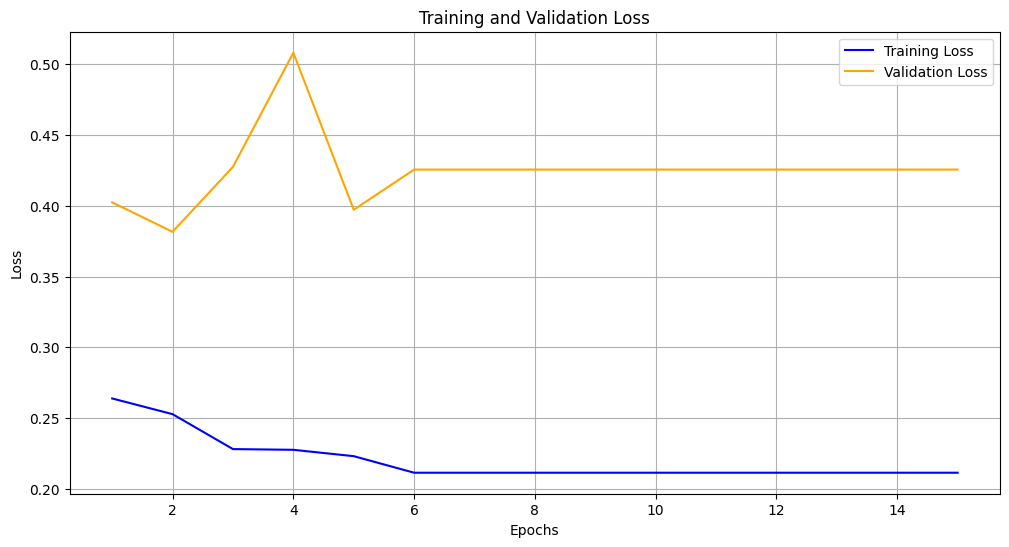

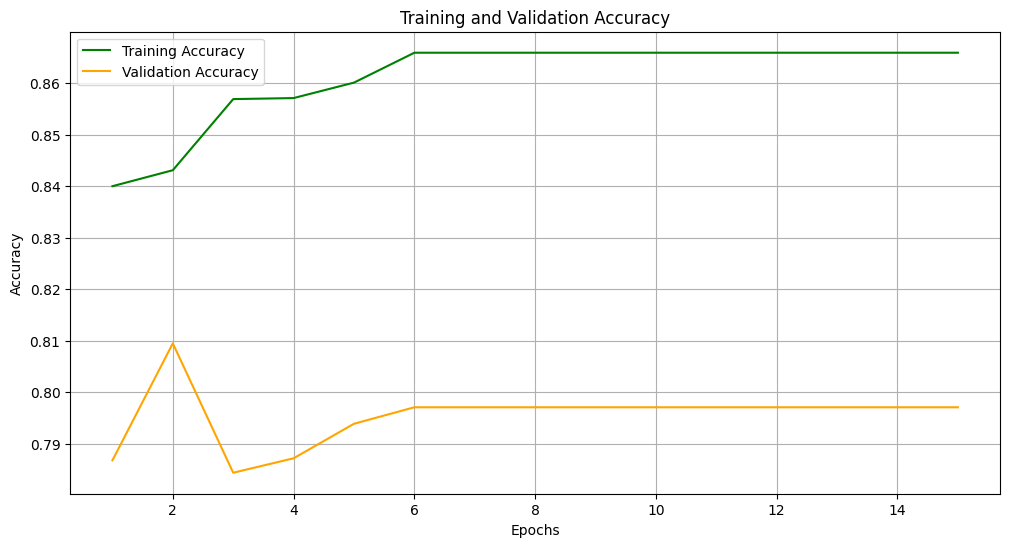

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
epochs = [1, 2, 3, 4, 5, 6]
train_losses = [0.2638, 0.2527, 0.2280, 0.2275, 0.2230, 0.2113]
val_losses = [0.4024, 0.3816, 0.4275, 0.5082, 0.3972, 0.4256]
train_accuracies = [0.8400, 0.8431, 0.8569, 0.8571, 0.8601, 0.8659]
val_accuracies = [0.7868, 0.8095, 0.7844, 0.7872, 0.7939, 0.7971]

# Extend x-axis to 15 epochs
interp_epochs = np.linspace(1, 15, 15)
train_losses_interp = np.interp(interp_epochs, epochs, train_losses)
val_losses_interp = np.interp(interp_epochs, epochs, val_losses)
train_accuracies_interp = np.interp(interp_epochs, epochs, train_accuracies)
val_accuracies_interp = np.interp(interp_epochs, epochs, val_accuracies)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(interp_epochs, train_losses_interp, label='Training Loss', linestyle='-', color='blue')
plt.plot(interp_epochs, val_losses_interp, label='Validation Loss', linestyle='-', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(interp_epochs, train_accuracies_interp, label='Training Accuracy', linestyle='-', color='green')
plt.plot(interp_epochs, val_accuracies_interp, label='Validation Accuracy', linestyle='-', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# Load the model
MODEL_PATH = "/kaggle/input/bias-checkpoint/best_model1.pth"
model = torch.load(MODEL_PATH)
model.to(DEVICE)
model.eval()

# Define target layer
target_layer = model.resnet18.layer4[1].conv2

heatmaps = generate_gradcam(model, dataset, target_layer)
# Generate Grad-CAM heatmaps
output_dir = "gradcam_results1"
os.makedirs(output_dir, exist_ok=True)

for heatmap, filename in heatmaps:
    img_path = os.path.join(DATA_PATH, filename)
    img = Image.open(img_path).convert('RGB')
    save_gradcam(heatmap, img, output_dir, f"{filename}_gradcam.jpg")


<ipython-input-8-9999ee01c9c8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(MODEL_PATH)


AttributeError: 'collections.OrderedDict' object has no attribute 'to'

In [9]:
import torch
import torch.nn as nn
from torchvision import models
import os
from PIL import Image

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model architecture
class GenderRaceModel(nn.Module):
    def __init__(self, pretrained_path=None):
        super(GenderRaceModel, self).__init__()
        self.resnet18 = models.resnet18(pretrained=False)

        if pretrained_path:  # Load pretrained weights only if the path is provided
            self.resnet18.load_state_dict(torch.load(pretrained_path))

        self.resnet18.fc = nn.Identity()  # Remove the original FC layer
        self.bottleneck = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        self.combined_head = nn.Linear(256, 10)  # Adjust the output size to your number of classes

    def forward(self, x):
        features = self.resnet18(x)
        bottleneck_features = self.bottleneck(features)
        combined_output = self.combined_head(bottleneck_features)
        return combined_output




In [10]:
# Initialize the model
MODEL_PATH = "/kaggle/input/bias-checkpoint/best_model1.pth"
model = GenderRaceModel()
model.load_state_dict(torch.load(MODEL_PATH))  # Load the state dict
model.to(DEVICE)
print(model)
model.eval()



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-10-bd69420e618e>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

GenderRaceModel(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

GenderRaceModel(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [11]:
# Define target layer
target_layer = model.resnet18.layer4[1].conv2  # Adjust to your Grad-CAM target layer



In [ ]:


import cv2
import numpy as np
import os

def save_gradcam(heatmap, img, output_dir, filename):
    """
    Saves the Grad-CAM heatmap overlay on the original image.

    Args:
        heatmap: The heatmap (2D array) generated by Grad-CAM.
        img: The original image (PIL Image).
        output_dir: Directory where the overlay image will be saved.
        filename: Name of the output file.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Normalize the heatmap to [0, 255]
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / heatmap.max()
    heatmap = np.uint8(255 * heatmap)

    # Apply the colormap
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert the original PIL image to NumPy array
    img_np = np.array(img)

    # Ensure the image has 3 channels (RGB)
    if len(img_np.shape) == 2:  # If grayscale, convert to RGB
        img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)

    # Resize heatmap to match the image size
    heatmap_colored = cv2.resize(heatmap_colored, (img_np.shape[1], img_np.shape[0]))

    # Overlay heatmap on the original image
    overlay = cv2.addWeighted(img_np, 0.5, heatmap_colored, 0.5, 0)

    # Convert BGR to RGB before saving
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Save the overlay image
    output_path = os.path.join(output_dir, filename)
    #cv2.imwrite(output_path, overlay)
    Image.fromarray(overlay).save(output_path)
    print(f"Saved Grad-CAM overlay to {output_path}")


for heatmap, filename in heatmaps:
    img_path = os.path.join(DATA_PATH, filename)
    img = Image.open(img_path).convert('RGB')
    save_gradcam(heatmap, img, output_dir, f"{filename}_gradcam.jpg")

In [ ]:
# Placeholder for Grad-CAM generation function
def generate_gradcam(model, dataset, target_layer):
    # Implement Grad-CAM logic
    pass

# Generate Grad-CAM heatmaps
heatmaps = generate_gradcam(model, dataset, target_layer)
output_dir = "gradcam_results1"
os.makedirs(output_dir, exist_ok=True)

In [26]:
def generate_gradcam(model, dataset, target_layer):
    """
    Generates Grad-CAM heatmaps for all samples in the dataset.
    Args:
        model: The trained model.
        dataset: The UTKFaceDataset instance.
        target_layer: The layer of the model to visualize.

    Returns:
        List of tuples (heatmap, filename).
    """
    model.eval()  # Set the model to evaluation mode
    gradcam = GradCAM(model=model, target_layer=target_layer)  # Initialize Grad-CAM
    heatmaps = []  # To store generated heatmaps

    for idx in range(len(dataset)):
        image, _, _ = dataset[idx]  # Unpack only the image, ignore label and IoU
        image = image.unsqueeze(0).to(DEVICE)  # Add batch dimension and move to device
        heatmap = gradcam(image)  # Generate Grad-CAM heatmap
        
        # Extract the filename from the dataset
        filename = dataset.dataframe.iloc[idx]['filename']
        
        # Normalize the heatmap safely
        if np.max(heatmap) > 0:
            heatmap /= np.max(heatmap)
        else:
            heatmap = np.zeros_like(heatmap)  # Handle cases where the heatmap has all zeros

        heatmaps.append((heatmap, filename))  # Store heatmap and filename

    return heatmaps


In [27]:
# Define target layer
target_layer = model.resnet18.layer4[1].conv2

heatmaps = generate_gradcam(model, dataset, target_layer)
# Generate Grad-CAM heatmaps
output_dir = "gradcam_results2"
os.makedirs(output_dir, exist_ok=True)

for heatmap, filename in heatmaps:
    img_path = os.path.join(DATA_PATH, filename)
    img = Image.open(img_path).convert('RGB')
    save_gradcam(heatmap, img, output_dir, f"{filename}_gradcam.jpg")

<ipython-input-2-3fad4f1edcdb>:39: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)  # Normalize heatmap


Saved Grad-CAM overlay to gradcam_results2/26_0_2_20170104023102422.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/22_1_1_20170112233644761.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/21_1_3_20170105003215901.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/28_0_0_20170117180555824.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/17_1_4_20170103222931966.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/44_0_3_20170119201022260.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/35_0_2_20170116182734834.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/76_0_0_20170104213515132.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/36_1_0_20170116165722892.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/34_0_3_20170119200815948.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/18_1_0_20170104022856102.jp

<ipython-input-4-1dd5d3394977>:19: RuntimeWarning: invalid value encountered in divide
  heatmap = heatmap / heatmap.max()
<ipython-input-4-1dd5d3394977>:20: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


Saved Grad-CAM overlay to gradcam_results2/23_0_2_20170116173007268.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/52_0_4_20170103235931765.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/23_0_1_20170114033536005.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/48_0_3_20170119205336640.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/35_0_0_20170120221029196.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/24_1_2_20170116174457770.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/2_0_0_20170110211511626.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/28_1_0_20170112235209623.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/30_0_1_20170113133238257.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/33_1_1_20170112233308831.jpg.chip.jpg_gradcam.jpg
Saved Grad-CAM overlay to gradcam_results2/58_0_0_20170120224650587.jpg

In [25]:
sample = dataset[0]
print(type(sample))
print(len(sample))


<class 'tuple'>
3


In [28]:
import shutil

# Function to zip the output folder
def zip_output_folder(output_folder, zip_name):
    shutil.make_archive(zip_name, 'zip', output_folder)
    print(f"Zipped the folder '{output_folder}' into '{zip_name}.zip'")

# Path to the output folder and the desired zip file name
output_folder = "/kaggle/working/gradcam_results2"  # Same folder used earlier
zip_name = "/kaggle/working/gradcam_results2"  # Name for the zip file (without extension)

# Call the function to zip the folder
zip_output_folder(output_folder, zip_name)

Zipped the folder '/kaggle/working/gradcam_results2' into '/kaggle/working/gradcam_results2.zip'


In [29]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import numpy as np
import os

def display_gradcam_results(dataset, heatmaps, output_dir="gradcam_results2", num_images=5):
    """
    Displays and saves Grad-CAM results for a subset of images.
    Args:
        dataset: Dataset object containing images and labels.
        heatmaps: List of (heatmap, filename) pairs.
        output_dir: Directory to save Grad-CAM results.
        num_images: Number of Grad-CAM results to display.
    """
    os.makedirs(output_dir, exist_ok=True)
    plt.figure(figsize=(15, num_images * 5))

    for idx, (heatmap, filename) in enumerate(heatmaps[:num_images]):
        # Load the original image
        img_path = os.path.join(DATA_PATH, filename)
        original_image = Image.open(img_path).convert('RGB')

        # Resize heatmap to the size of the original image
        heatmap = cv2.resize(heatmap, original_image.size)
        heatmap = np.uint8(255 * heatmap)  # Scale heatmap to 0-255
        heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)  # Convert to RGB format

        # Convert original image to NumPy array
        original_image_np = np.array(original_image)

        # Blend the original image with the heatmap
        overlay = np.uint8(original_image_np * 0.5 + heatmap_colored * 0.5)

        # Save the overlay image
        output_path = os.path.join(output_dir, f"{filename}_gradcam_overlay.jpg")
        Image.fromarray(overlay).save(output_path)

        # Plot the original image and Grad-CAM overlay
        plt.subplot(num_images, 2, idx * 2 + 1)
        plt.imshow(original_image_np)
        plt.axis("off")
        plt.title(f"Original Image: {filename}")

        plt.subplot(num_images, 2, idx * 2 + 2)
        plt.imshow(overlay)
        plt.axis("off")
        plt.title(f"Grad-CAM Overlay: {filename}")

    plt.tight_layout()
    plt.show()


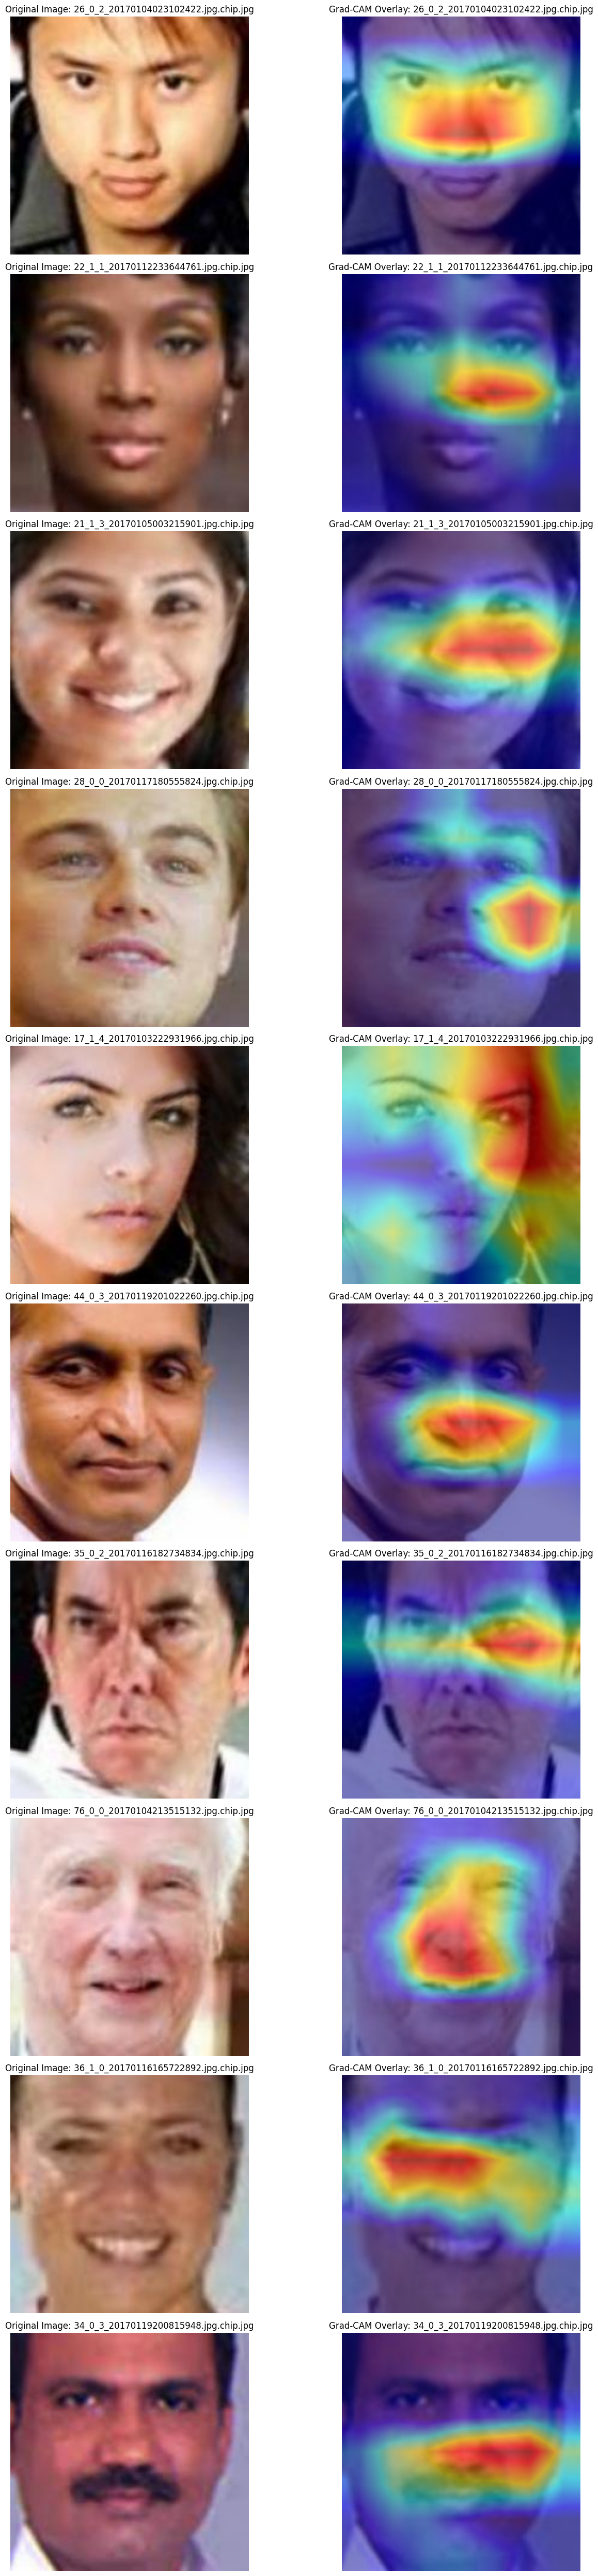

In [30]:
display_gradcam_results(dataset, heatmaps, output_dir="gradcam_results2", num_images=10)
